# ALGORITHM

In [1]:
from LibraryENG import *
name_data = '2018-11-28T12-47-25Pop3 Control.h5'
complete_string = '../LRRK2_data/Baseline_healthy/'+ name_data

### DATA READING

In [2]:
data = h5py.File(name_data,'r')
data_readings = data['Data']['Recording_0']['AnalogStream']['Stream_0']['ChannelData'][()]
info = data['Data']['Recording_0']['AnalogStream']['Stream_0']['InfoChannel'][()]
info_table = pd.DataFrame(info, columns = list(info.dtype.fields.keys()))
labels = info_table['Label']
readings = pd.DataFrame(data = data_readings.transpose(), columns = labels)
fs = 10000 #Sampling Frequency

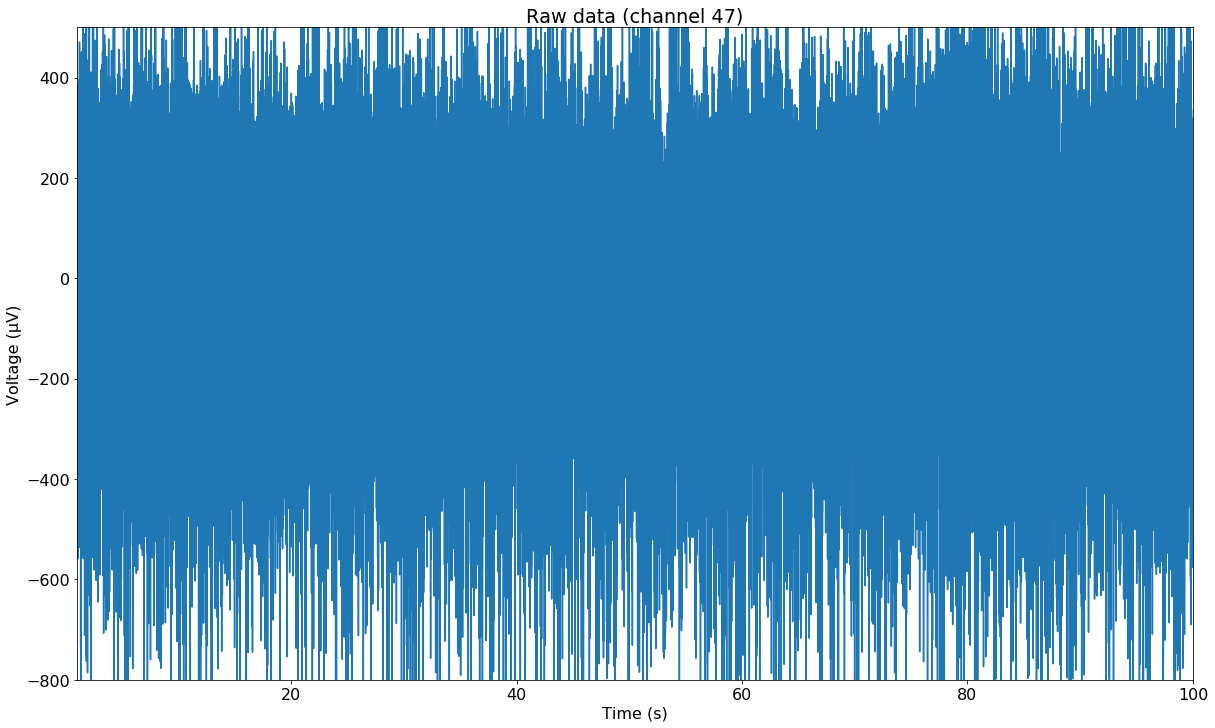

In [3]:
plt.figure(figsize=(20,12))
plt.rcParams.update({'font.size': 16})
plt.plot([x/10000 for x in range (0,readings.shape[0])],readings[b'47'])
plt.axis([1,100,-800,500])
plt.title('Raw data (channel 47)')
plt.ylabel ('Voltage (\u03BCV)')
plt.xlabel('Time (s)')
plt.show()

### PRELIMINAR FILTERING
- We found noises at low frequencies (up to 150Hz). We filtered up to 200Hz to remove the noise.
- We also found weird noises at 453Hz and 906Hz (double its frequency like an harmonic). In this dataset the noise is only present in the Reference Channel, however in other datasets it is present in every channel. We supposed they were due to the acquisition system's impedances. We filtered those frequencies with two notch filters

From now on we used this filtered signal

100%|██████████| 10/10 [00:01<00:00,  9.12it/s]


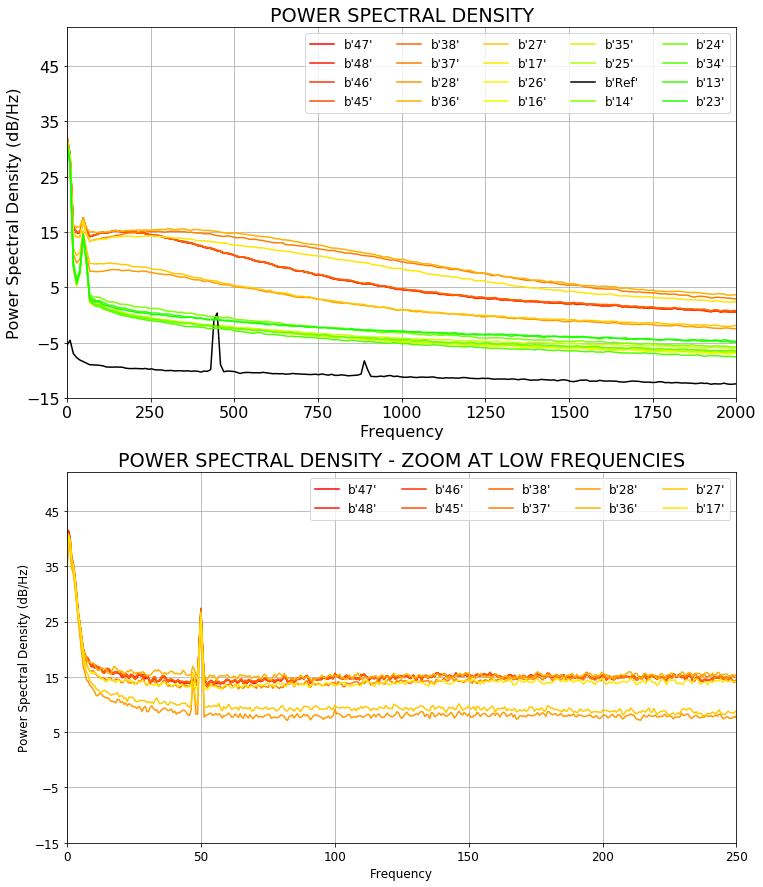

In [4]:
colormap = cm.get_cmap('hsv')
plt.figure(figsize=(12,15))

plt.subplot(2, 1, 1)
plt.rcParams.update({'font.size': 16})
plt.title('POWER SPECTRAL DENSITY')
column = 0
for electrode in tqdm(readings.columns[:20]):
    if electrode == b'Ref':
        plt.psd(readings[electrode],1024 ,Fs=fs,window=np.hamming(1024),noverlap=50, label=electrode, color = "#000000")
    else:
        plt.psd(readings[electrode],1024 ,Fs=fs,window=np.hamming(1024),noverlap=50, label=electrode, color = colormap(np.linspace(0, 1, 60))[column])
    plt.axis([0,2000,-15,52])
    column +=1
plt.rcParams.update({'font.size': 12})
plt.legend(loc='upper right', ncol=5)


plt.subplot(2, 1, 2)
plt.rcParams.update({'font.size': 16})
plt.title('POWER SPECTRAL DENSITY - ZOOM AT LOW FREQUENCIES')
column = 0
for electrode in tqdm(readings.columns[:10]):
    if electrode == b'Ref':
        plt.psd(readings[electrode],1024*16 ,Fs=fs,window=np.hamming(1024*16),noverlap=50, label=electrode, color = "#000000")
    else:
        plt.psd(readings[electrode],1024*16 ,Fs=fs,window=np.hamming(1024*16),noverlap=50, label=electrode, color = colormap(np.linspace(0, 1, 60))[column])
    plt.axis([0,250,-15,52])
    column +=1
plt.rcParams.update({'font.size': 12})
plt.legend(loc='upper right', ncol=5)


plt.show()

100%|██████████| 60/60 [00:07<00:00,  7.72it/s]


449.21875


100%|██████████| 60/60 [00:06<00:00,  9.27it/s]


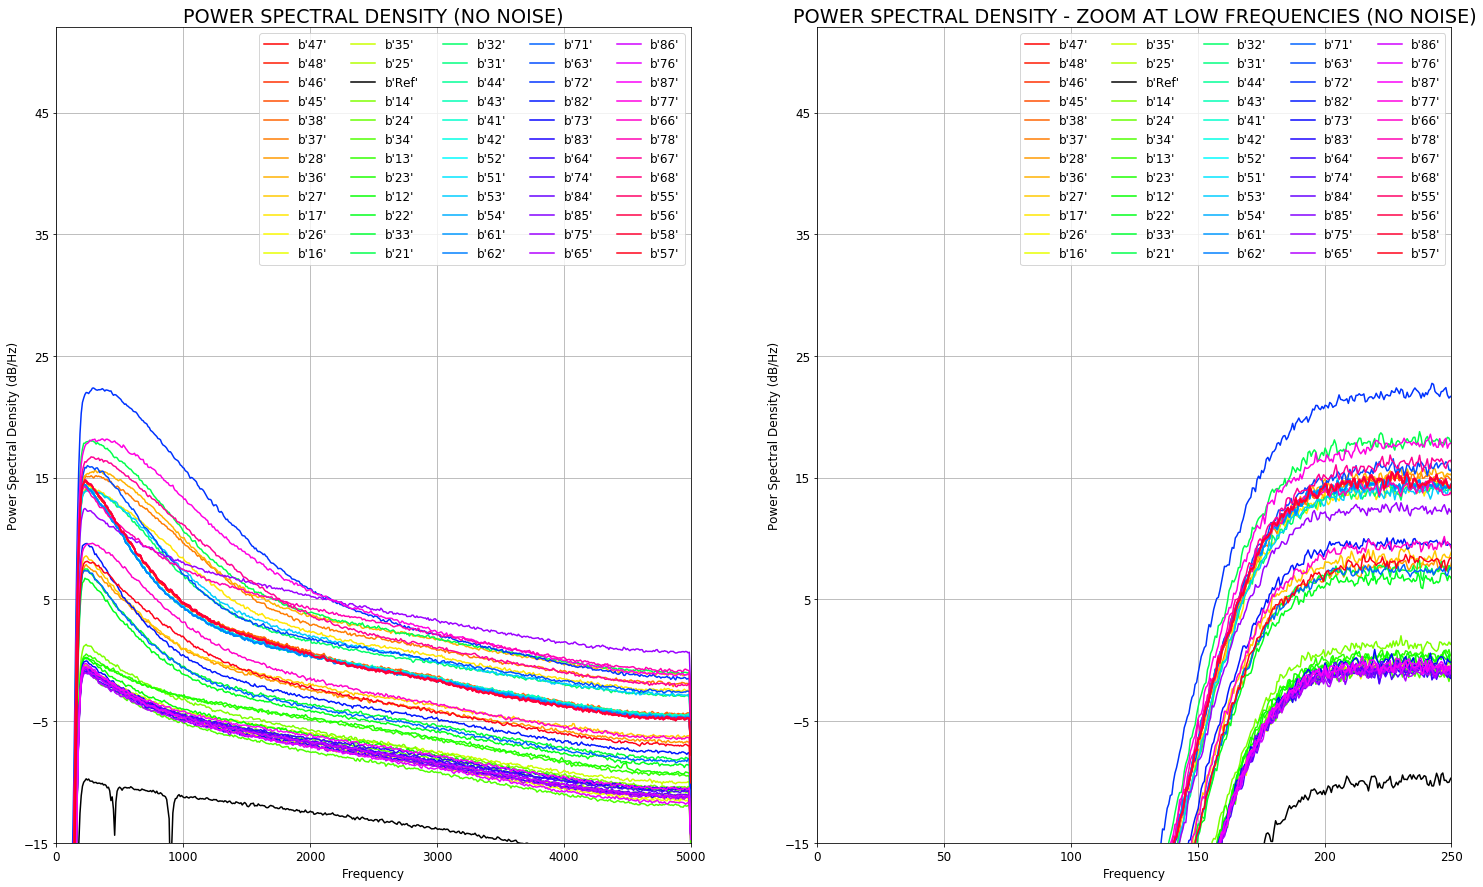

In [5]:
#PREFILTERING
#Low Frequencies
readings_rows = range(readings.shape[0])
reading_columns = range(readings.shape[1])
pre_filtered_readings = pd.DataFrame(data = 0, columns=readings.columns, index=readings_rows, dtype = "float32")

b, a = scipy.signal.butter(N = 8, Wn=175, btype='highpass', analog=False, output='ba', fs=fs)
for x in tqdm(range(readings.shape[1])):
    pre_filtered_readings.values[:,x] = scipy.signal.filtfilt(b, a, readings.values[:,x])
    
# Find noisy peaks on Ref channel
from scipy import signal
freqs,spectrogram = signal.welch(pre_filtered_readings[b'Ref'].values,fs=10000,nfft=1024)
noise_freq = freqs[spectrogram.argmax()]
print(noise_freq)
Q = 30
b, a = scipy.signal.iirnotch(noise_freq, Q, fs)
Q = 60
b_2, a_2 = scipy.signal.iirnotch(2*noise_freq, Q, fs)

channel = pre_filtered_readings[b'Ref'].values
pre_filtered_ref = scipy.signal.filtfilt(b, a, channel)
pre_filtered_ref = scipy.signal.filtfilt(b_2, a_2, pre_filtered_ref) 
pre_filtered_readings[b'Ref'] = pre_filtered_ref

#Prefiltered plot
colormap = cm.get_cmap('hsv')
plt.figure(figsize=(25,15))
plt.subplot(1, 2, 1)
plt.rcParams.update({'font.size': 16})
plt.title('POWER SPECTRAL DENSITY (NO NOISE)')
column = 0
for electrode in tqdm(readings.columns):
    if electrode == b'Ref':
        plt.psd(pre_filtered_readings[electrode],1024 ,Fs=fs,window=np.hamming(1024),noverlap=50, label=electrode, color = "#000000")
    else:
        plt.psd(pre_filtered_readings[electrode],1024 ,Fs=fs,window=np.hamming(1024),noverlap=50, label=electrode, color = colormap(np.linspace(0, 1, 60))[column])
    plt.axis([0,5000,-15,52])
    column +=1
plt.rcParams.update({'font.size': 12})
plt.legend(loc='upper right', ncol=5)


plt.subplot(1, 2, 2)
plt.rcParams.update({'font.size': 16})
plt.title('POWER SPECTRAL DENSITY - ZOOM AT LOW FREQUENCIES (NO NOISE)')
column = 0
for electrode in tqdm(readings.columns):
    if electrode == b'Ref':
        plt.psd(pre_filtered_readings[electrode],1024*16 ,Fs=fs,window=np.hamming(1024*16),noverlap=50, label=electrode, color = "#000000")
    else:
        plt.psd(pre_filtered_readings[electrode],1024*16 ,Fs=fs,window=np.hamming(1024*16),noverlap=50, label=electrode, color = colormap(np.linspace(0, 1, 60))[column])
    plt.axis([0,250,-15,52])
    column +=1
plt.rcParams.update({'font.size': 12})
plt.legend(loc='upper right', ncol=5)


plt.show()

### SEARCHING FOR THE FREQUENCIES OF SPIKES
In this section we searched for the frequencies which are typical of spikes doing a STFT (Short Time Fourier Transform).
<br>
We found the typical frequencies of 300Hz 3000Hz cited in various papers well fit our data. 
<br>
- Low frequencies are important for spike amplitude (especially for the slowest ones)
- High frequencies are important for the morphology of the spikes

"#Short Time Fourier Transform\nplt.figure(figsize=(26,18))\nplt.subplot(2, 1, 2)\nf, t, Sxx = scipy.signal.stft(x = pre_filtered_readings[electrode_example].values[t_initial:t_initial+lenght], fs=fs, window='boxcar', nperseg=2**6, noverlap=None, nfft=2**9)\nplt.pcolormesh(t*fs+t_initial, f, np.abs(Sxx))\nplt.colorbar()\nplt.ylabel('Frequency [Hz]')\nplt.xlabel('Samples')\nplt.axis\nplt.ylim([0,5000])\n\nplt.show()"

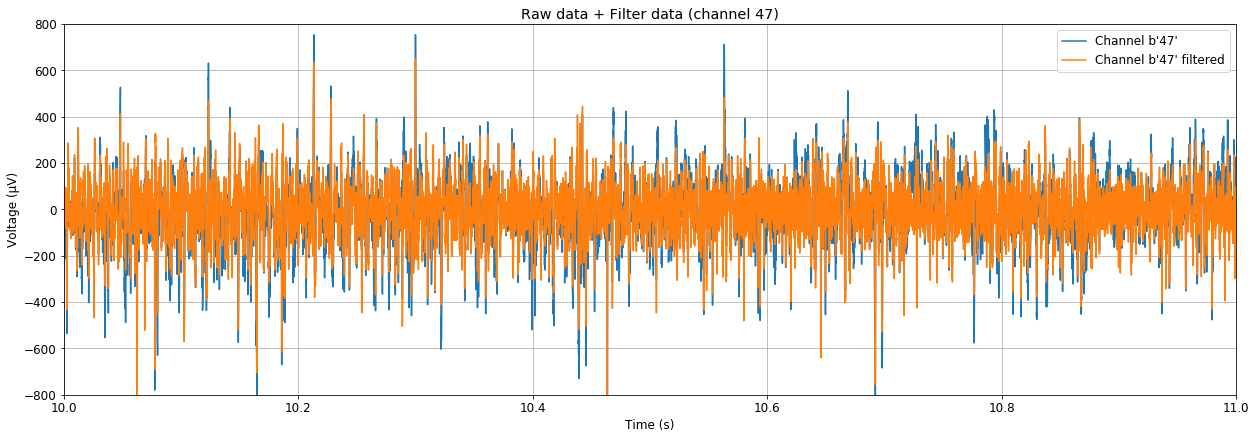

In [6]:
electrode_example = b'47' #Change the name here to change the electrode

t_initial = 10 #Change the number here to select a different initial position
lenght = 1 #Change the number here to enlarge or reduce the x axis (time)

#Time domain signal
plt.figure(figsize=(21,15))
plt.subplot(2, 1, 1)
label = "Channel " + str(electrode_example)
plt.plot([x/10000 for x in range (0,readings.shape[0])],readings[electrode_example].values, label=label)
plt.plot([x/10000 for x in range (0,readings.shape[0])],pre_filtered_readings[electrode_example].values, label=label+' filtered')

plt.axis([t_initial,t_initial+lenght, -800, 800])
plt.title('Raw data + Filter data (channel 47)')
plt.ylabel ('Voltage (\u03BCV)')
plt.xlabel('Time (s)')
plt.grid()
plt.legend(loc="upper right")

'''#Short Time Fourier Transform
plt.figure(figsize=(26,18))
plt.subplot(2, 1, 2)
f, t, Sxx = scipy.signal.stft(x = pre_filtered_readings[electrode_example].values[t_initial:t_initial+lenght], fs=fs, window='boxcar', nperseg=2**6, noverlap=None, nfft=2**9)
plt.pcolormesh(t*fs+t_initial, f, np.abs(Sxx))
plt.colorbar()
plt.ylabel('Frequency [Hz]')
plt.xlabel('Samples')
plt.axis
plt.ylim([0,5000])

plt.show()'''

### FILTERING
We tried the following filters:
1. FIR (Hamming window)
2. FIR (Blackman-Nuttall window)
3. IIR (Butterworth)

We found the filter order was not so relevant and we decided to filter the signal with the Butterworth one (due to maximal flatness) between 300Hz and 3000Hz 

100%|██████████| 60/60 [00:08<00:00,  7.12it/s]


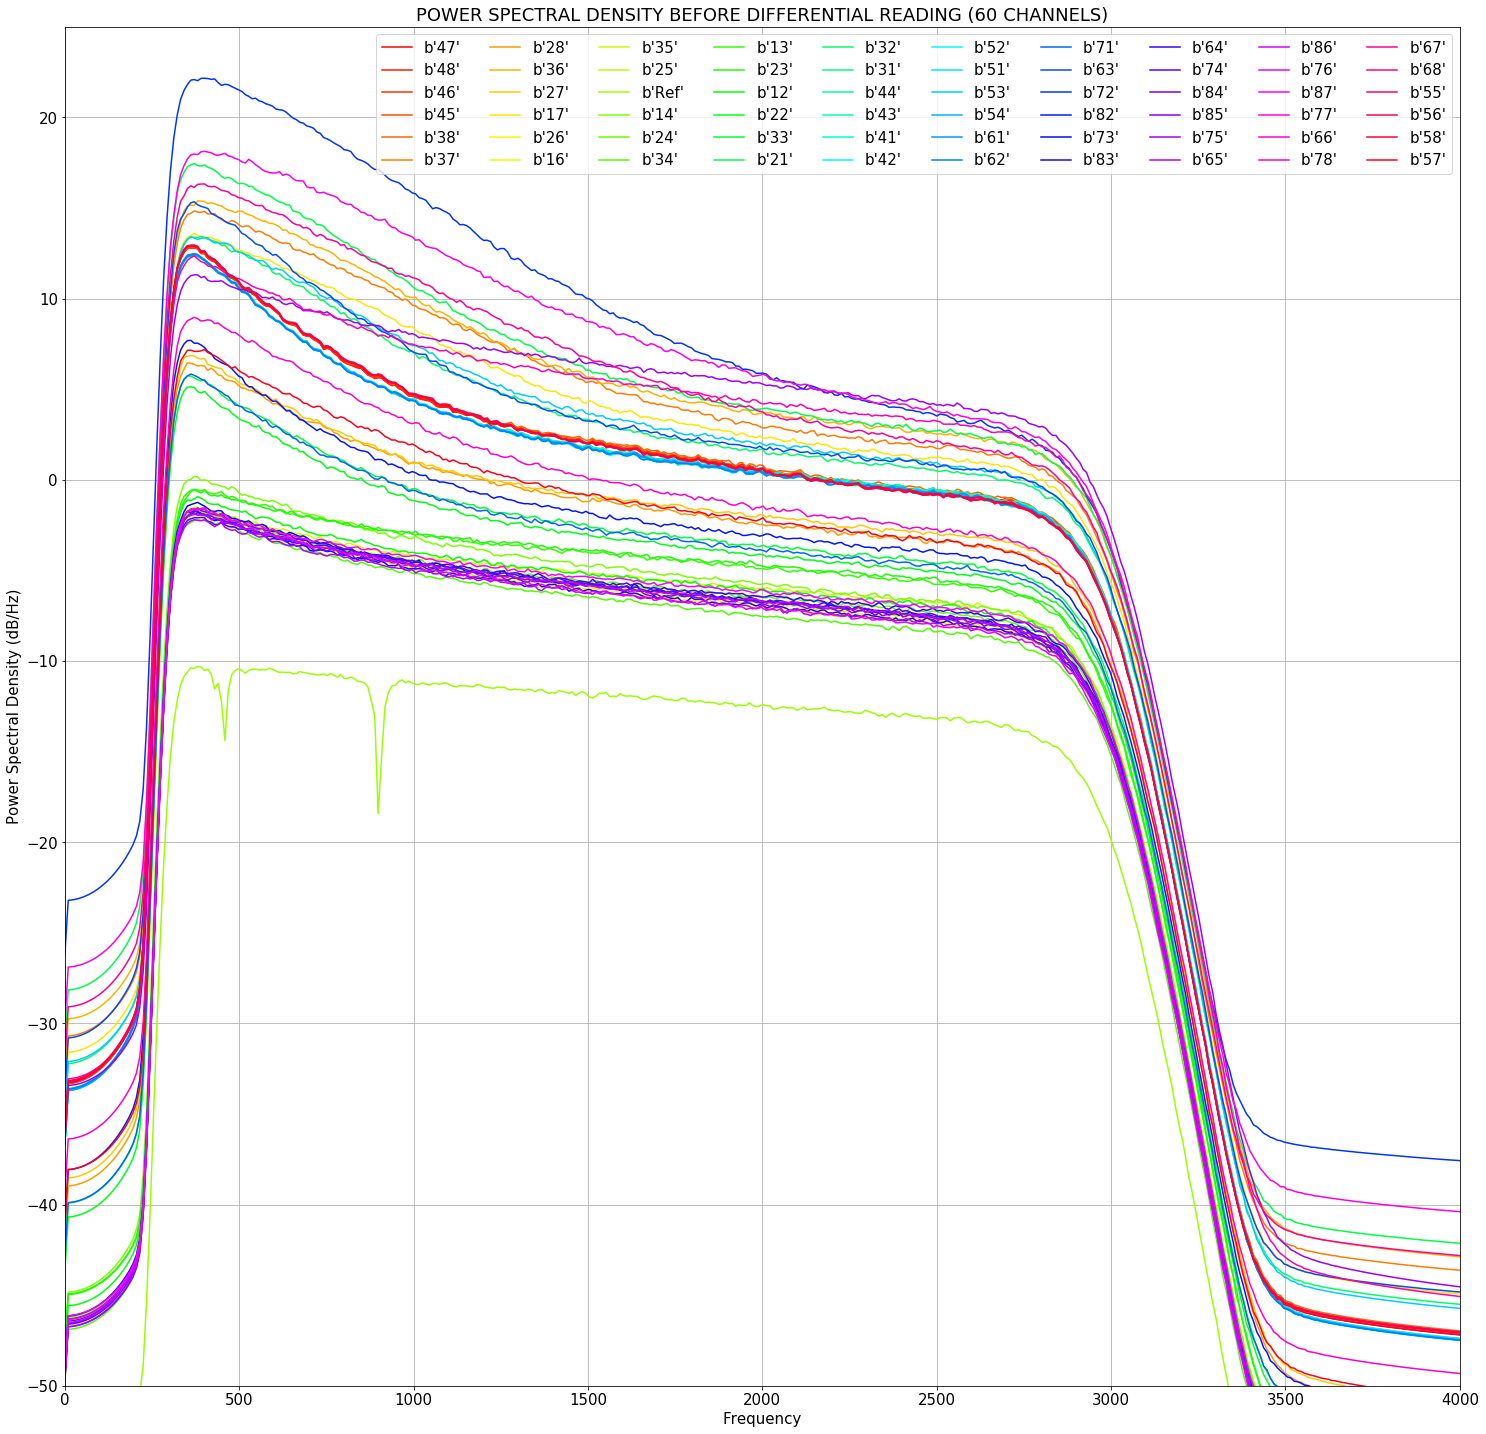

In [7]:
lowcut = 300
highcut = 3000

readings_rows = range(readings.shape[0])
reading_columns = range(readings.shape[1])
filtered_readings = pd.DataFrame(data = 0, columns=pre_filtered_readings.columns, index=readings_rows, dtype = "float32")

elab = pre_filtered_readings.values

order=8
for x in tqdm(range(filtered_readings.shape[1])):
    filtered_readings.values[:,x] = butter_bandpass_filter(elab[:,x], lowcut, highcut, fs, order=order)
    
plt.figure(figsize=(25,25))
plt.rcParams.update({'font.size': 15})
column = 0
colormap = cm.get_cmap('hsv')
for electrode in tqdm(filtered_readings.columns):
    plt.psd(filtered_readings[electrode], 1024, Fs = fs, window=np.hamming(1024), noverlap=50, label=electrode, color = colormap(np.linspace(0, 1, 60))[column])
    plt.axis([0,4000,-50,25])
    plt.title('POWER SPECTRAL DENSITY BEFORE DIFFERENTIAL READING (60 CHANNELS)')
    column +=1
plt.legend(loc='upper right', ncol=10)
plt.show()

del readings
del pre_filtered_readings
del elab

### DIFFERENTIAL READING
We subtracted the reference channel and executed a differential reading

In [8]:
for electrode in filtered_readings.columns:
    filtered_readings[electrode] = filtered_readings[electrode] - filtered_readings[b'Ref']
filtered_readings = filtered_readings.drop([b'Ref'],axis = 1)

### CORRELATION MATRIX AND DELETION OF HIGH CORRELATED CHANNELS

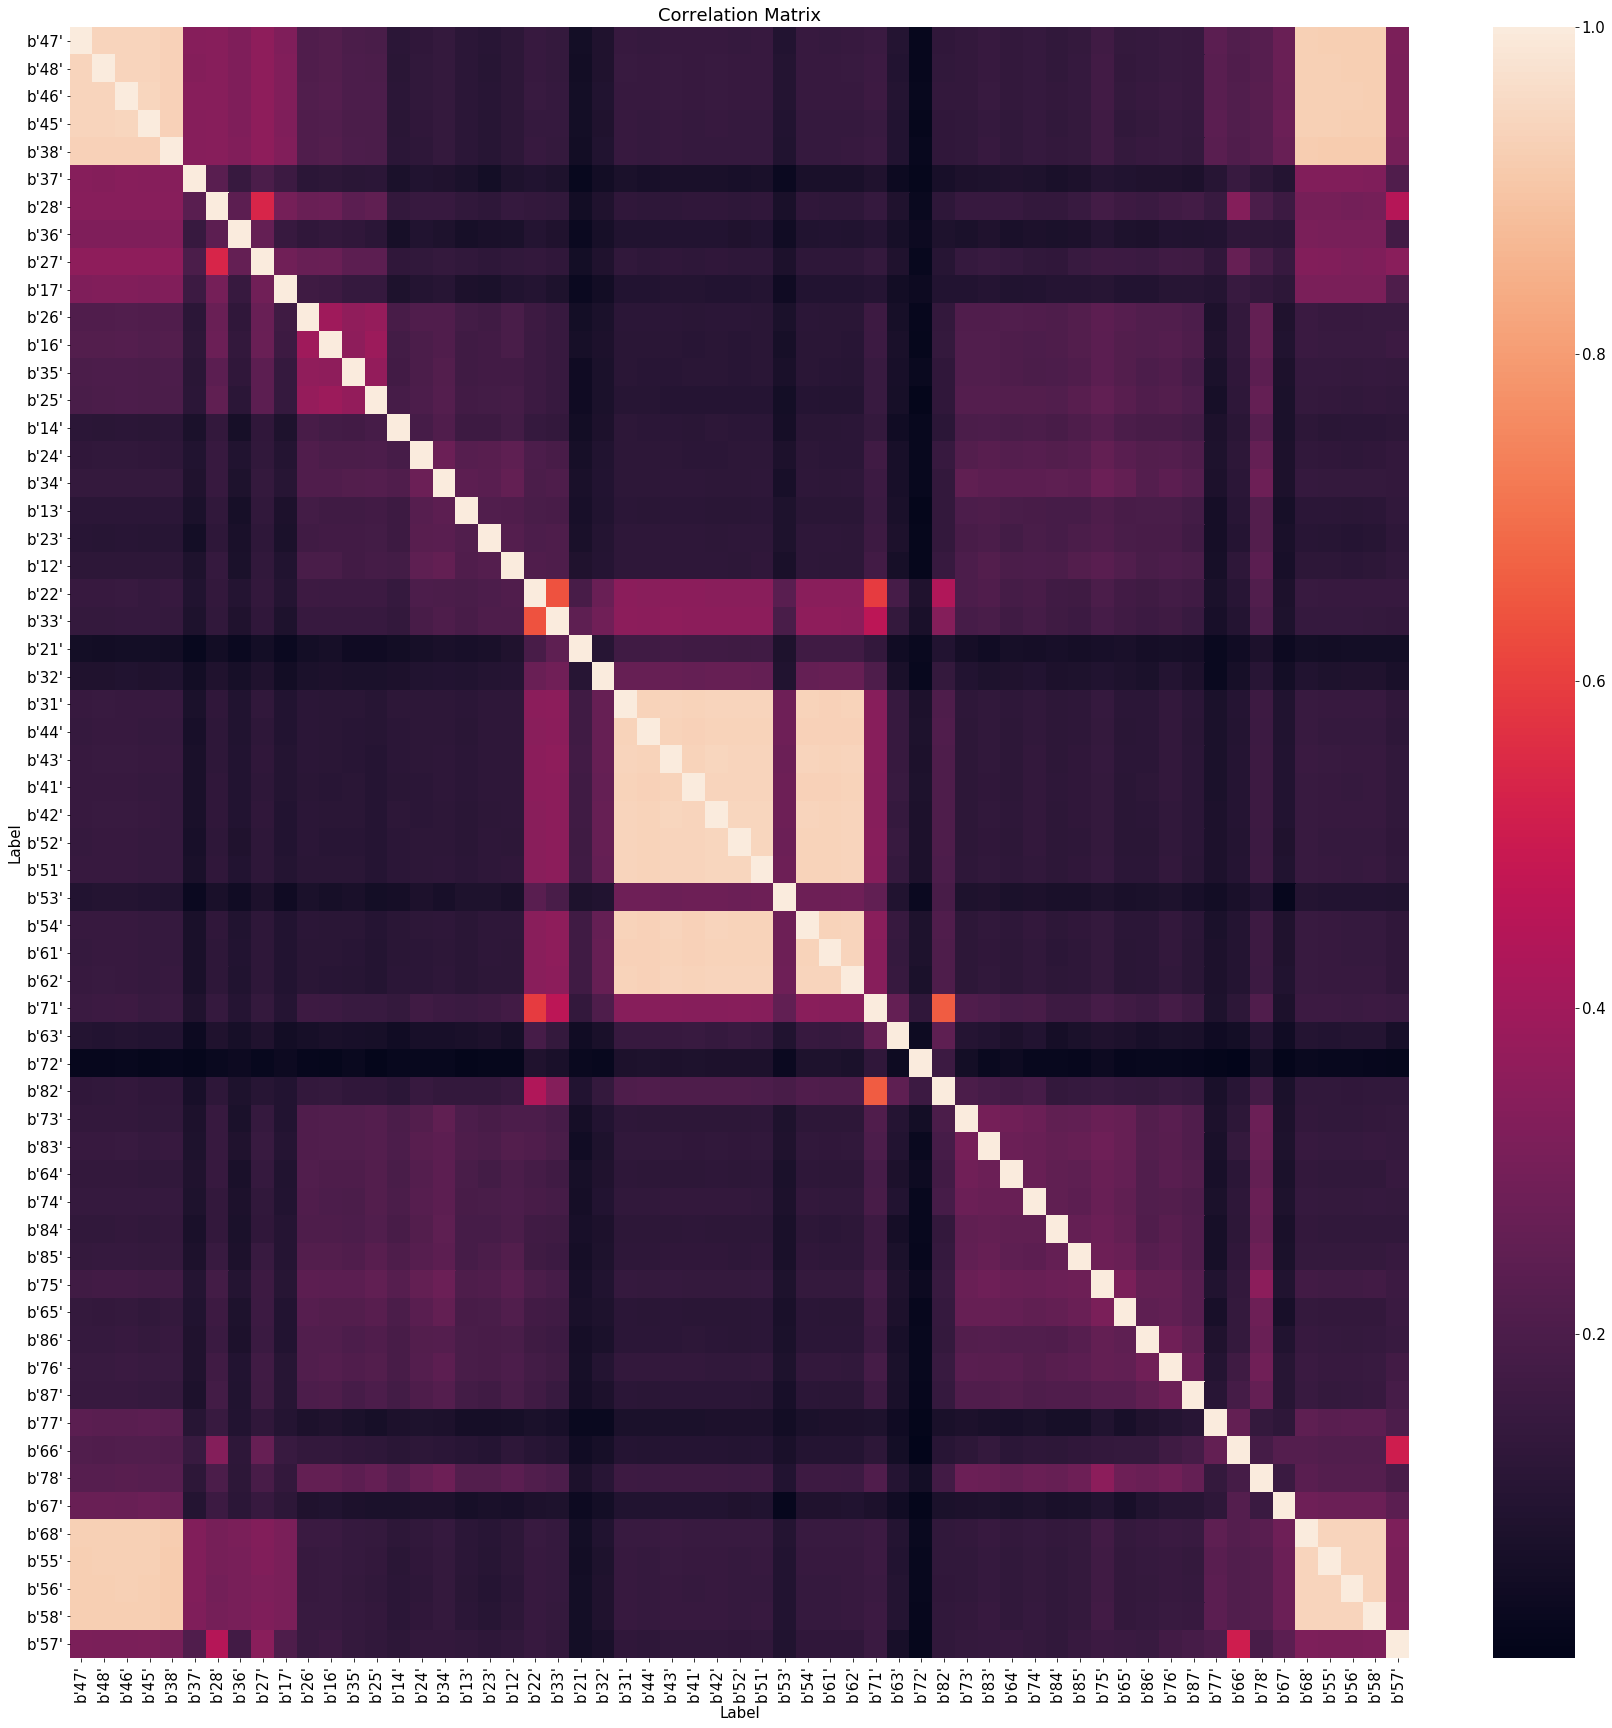

In [9]:
corr_matrix = filtered_readings.iloc[:50000,:].corr()
plt.figure(figsize=(30,30))
sns.heatmap(corr_matrix, annot=False, yticklabels = True)
plt.title('Correlation Matrix')
plt.show()


The following 19 channels are correlated:  {b'38', b'52', b'55', b'47', b'44', b'68', b'41', b'61', b'43', b'62', b'54', b'42', b'46', b'31', b'51', b'48', b'45', b'56', b'58'} 
With a correlation over: 85.0 %



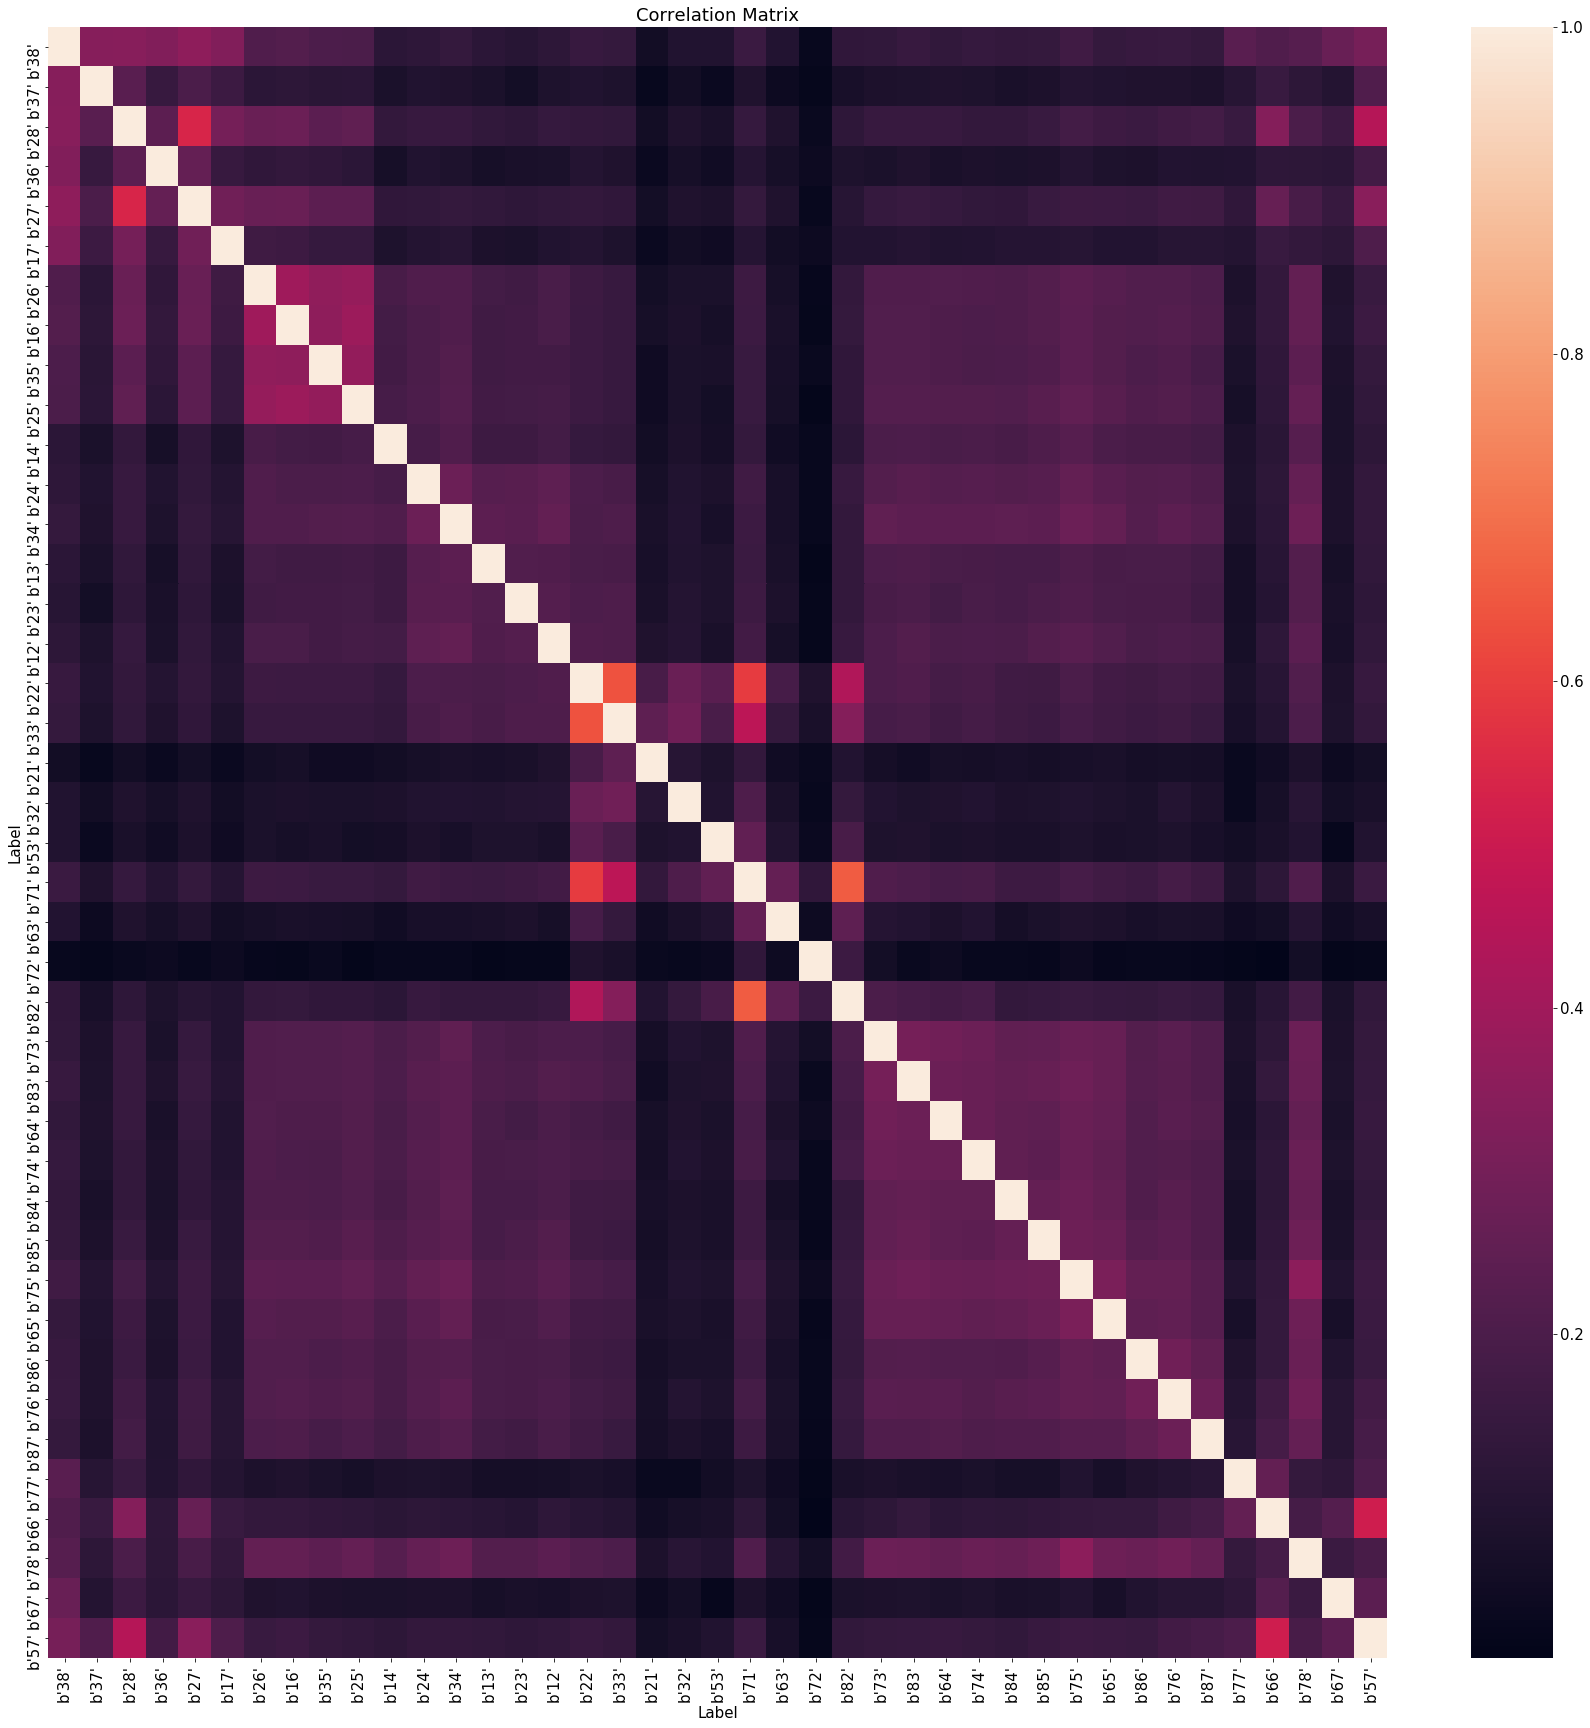

In [10]:
max_corr = 0.85

correlated_channels = set()

for column in corr_matrix.columns:
    for row in corr_matrix.index:
        if row != column and corr_matrix[row][column] > max_corr:
            correlated_channels.add(row)

print("\nThe following", len(correlated_channels),"channels are correlated: ", correlated_channels,"\nWith a correlation over:", max_corr*100, "%\n")

absolute_mean = dict()
for electrode in correlated_channels:
    absolute_mean[electrode] = np.mean(abs(filtered_readings[electrode].values))
    
#Keeping only the channel that has maximum absolute value
maximum_value = float(0)
maximum_name = ""
for electrode in absolute_mean:
    if absolute_mean[electrode] > maximum_value:
        maximum_value = absolute_mean[electrode]
        maximum_name = electrode

correlated_channels.remove(maximum_name)

#Deleting all the other channels from the correlation matrix
corr_matrix = corr_matrix.drop(labels = correlated_channels, axis=0)
corr_matrix = corr_matrix.drop(labels = correlated_channels, axis=1)

#Deleting all the other channels from the filtered readings
filtered_readings = filtered_readings.drop(columns = correlated_channels)

plt.figure(figsize=(30,30))
sns.heatmap(corr_matrix, annot=False, yticklabels = True)
plt.title('Correlation Matrix')
plt.show()

### THRESHOLD
We tried two ways of calculating the threshold:
1. Standard Deviation (SD)
2. Median Absolute Deviation (MAD)

We found that the two values didn't differ very much. Thus we opted for the estimator which better identified the noise variance, which is the MAD.
<br>

In [11]:
#You can choose "MAD" and "STD"
method = "MAD"

#Multiple
n = 4

In [12]:
if method == "MAD":
    deviation_list = pd.DataFrame(data = 0, columns=filtered_readings.columns, index=range(1))
    threshold = pd.DataFrame(data = 0, columns=filtered_readings.columns, index = range(1))
    for electrode in tqdm(filtered_readings.columns):
        deviation_list[electrode] = scipy.stats.median_absolute_deviation(filtered_readings[electrode].values)
        threshold[electrode] = (deviation_list[electrode])*n  
    
elif method == "STD":
    deviation_list = pd.DataFrame(data = 0, columns=filtered_readings.columns, index=range(1))
    threshold = pd.DataFrame(data = 0, columns=filtered_readings.columns, index = range(1))
    for electrode in tqdm(filtered_readings.columns):
        deviation_list[electrode] = np.std(filtered_readings[electrode].values)
        threshold[electrode] = (np.std(filtered_readings[electrode].values))*n

100%|██████████| 41/41 [00:09<00:00,  4.30it/s]


In [13]:
np.full(filtered_readings.shape[0],128)

array([128, 128, 128, ..., 128, 128, 128])

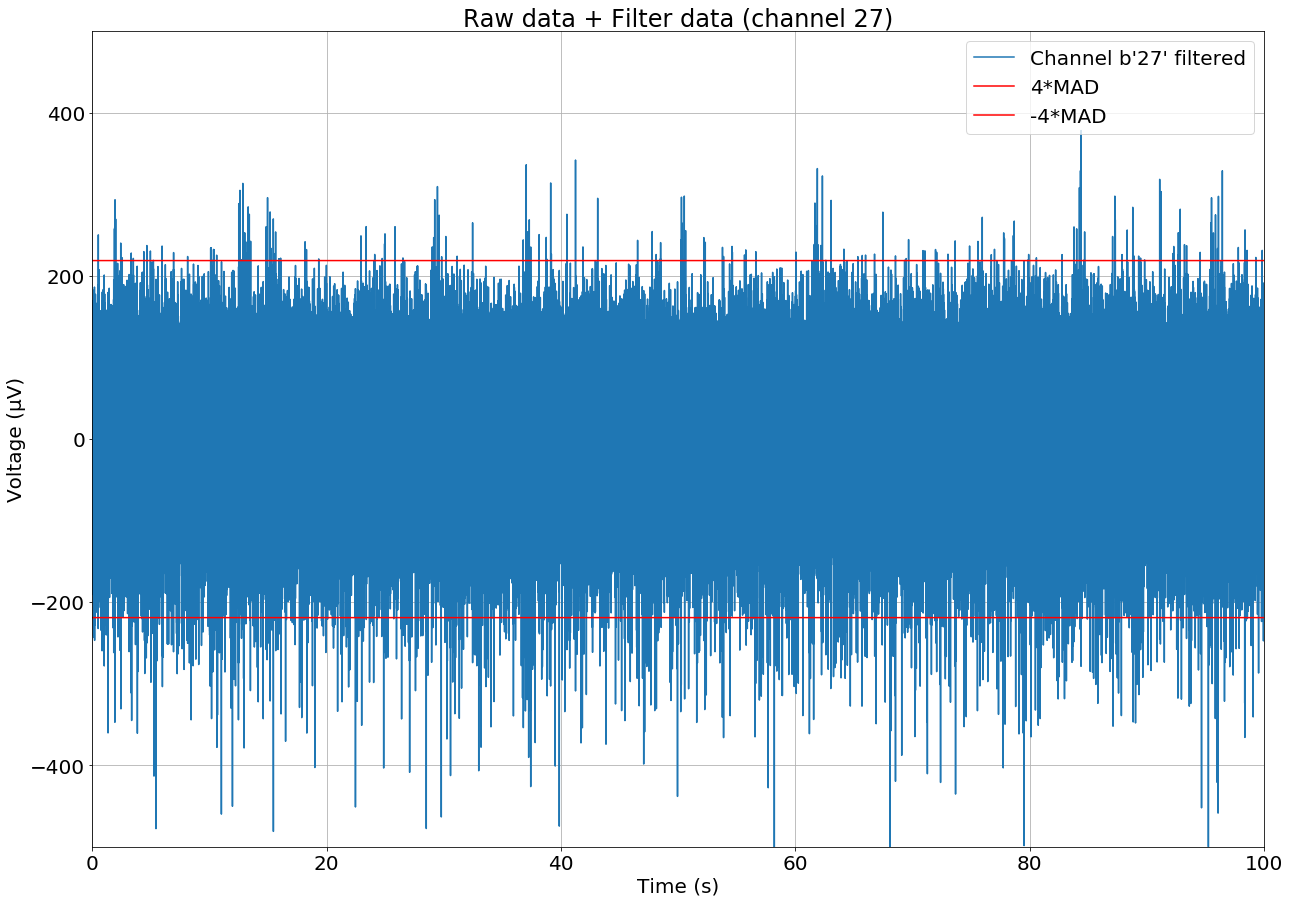

In [28]:
electrode_example = b'27' #Change the name here to change the electrode

t_initial = 0 #Change the number here to select a different initial position
lenght = 100 #Change the number here to enlarge or reduce the x axis (time)

#Time domain signal
plt.figure(figsize=(21,15))
label = "Channel " + str(electrode_example)
plt.plot([x/10000 for x in range (0,filtered_readings.shape[0])],filtered_readings[electrode_example].values, label=label+' filtered')
plt.plot([x/10000 for x in range (0,filtered_readings.shape[0])],np.full(filtered_readings.shape[0],threshold[electrode_example]),'r',label='4*MAD')
plt.plot([x/10000 for x in range (0,filtered_readings.shape[0])],np.full(filtered_readings.shape[0],-threshold[electrode_example]),'r',label = '-4*MAD')


plt.axis([t_initial,t_initial+lenght, -500, 500])
plt.title('Raw data + Filter data (channel 27)')
plt.ylabel ('Voltage (\u03BCV)')
plt.xlabel('Time (s)')
plt.grid()
plt.legend(loc="upper right")

### EXTRACT WAVEFORM
We then extracted the signal which exceeded the threshold. This signal is presumably the spikes

In [15]:
legend = pd.DataFrame(data = 0, columns=filtered_readings.columns, index=["corresponding number"])
indexes = []
aligned_indexes = []
extracted = []

i = 0
for electrode in tqdm(filtered_readings.columns):
    legend[electrode] = i
    sgn = filtered_readings[electrode].values
    thr = float(threshold[electrode].values[0])
    indexes.append(DetectSpike(segnale = sgn, soglia = thr, fs = fs))
    aligned_indexes.append(AlignSpike(segnale = sgn, indici = indexes[i], soglia = thr, fs = fs))
    extracted.append(ExtractSpike(segnale = sgn, indici = aligned_indexes[i], fs = fs))
    i+=1
    
del indexes

100%|██████████| 41/41 [04:28<00:00,  6.56s/it]


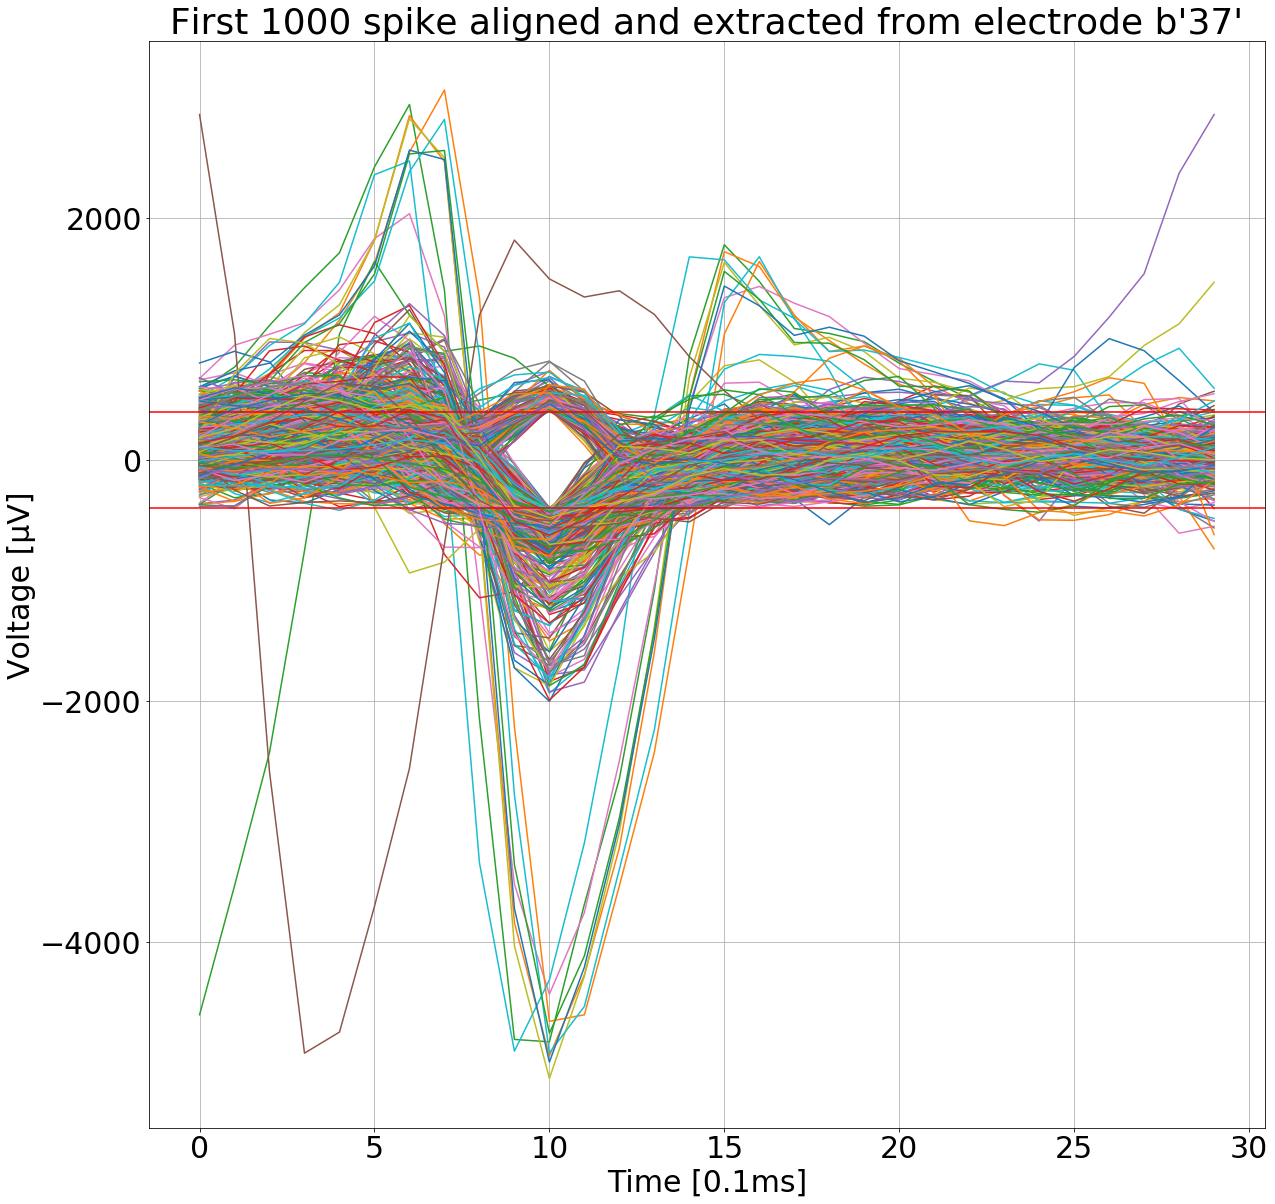

In [16]:
electrode_example = b'37' #Change the name here to change electrode

spike_count = 1000  #Change the number here to increase or decrase the spikes to draw. 
                    #To see all spikes use: len(extracted[legend[electrode_example]])

#Plot
plt.figure(figsize=(20,20))
plt.rcParams.update({'font.size': 30})
plt.xlabel('Time [0.1ms]')
plt.ylabel('Voltage [\u03BCV]')
i=0
while (i<spike_count):
    plt.plot(extracted[legend[electrode_example].values[0]][i])
    i += 1
plt.axhline(threshold[electrode_example].values, 0,1, color="#FF0000")
plt.axhline(-threshold[electrode_example].values, 0,1, color="#FF0000")
title = str("First ") + str(i) + str(" spike aligned and extracted from electrode ") + str(electrode_example)
plt.title(title)
plt.grid()
plt.show()

### EXTRACT SPIKE CHARACTERISTICS
We used 3 components principal analysis to extract and plot the characteristics of the spikes detected
<br>
30 dimensions (there were 30 sample points per spike) --> 3 Dimensions

In [17]:
principal_components = []
for electrode in filtered_readings.columns:
    print("\n\nELECTRODE: ", electrode)
    principal_components.append(EseguiPCA(dati=extracted[legend[electrode].values[0]], n=3, show=False))



ELECTRODE:  b'38'

Signal standardized
Mean:  -4.00330055339492e-18 
Variance:  0.9999999999999996 



ELECTRODE:  b'37'

Signal standardized
Mean:  1.3386973785081037e-18 
Variance:  1.0000000000000004 



ELECTRODE:  b'28'

Signal standardized
Mean:  -2.3356414066717598e-18 
Variance:  1.0 



ELECTRODE:  b'36'

Signal standardized
Mean:  -2.8142604425687395e-18 
Variance:  0.9999999999999996 



ELECTRODE:  b'27'

Signal standardized
Mean:  1.1495223189026406e-18 
Variance:  1.0000000000000009 



ELECTRODE:  b'17'

Signal standardized
Mean:  3.639029687860109e-18 
Variance:  0.9999999999999989 



ELECTRODE:  b'26'

Signal standardized
Mean:  1.5960242166829805e-17 
Variance:  1.0000000000000018 



ELECTRODE:  b'16'

Signal standardized
Mean:  -6.553499796605622e-18 
Variance:  0.9999999999999993 



ELECTRODE:  b'35'

Signal standardized
Mean:  8.947876466355011e-18 
Variance:  0.9999999999999987 



ELECTRODE:  b'25'

Signal standardized
Mean:  -1.9662672185799384e-17 
Varianc

### CLUSTERING
We tried 3 different ways of clustering the PCA results:
1. DBSCAN
2. K-Means
3. Hierarchical

In [18]:
plt.rcParams.update({'font.size': 20})

  0%|          | 0/41 [00:00<?, ?it/s]



ELECTRODE:  b'38'
Total spikes 9614

Spike detected as noise 1724

Number of clusters:  2 
The silhouette score is: 0.33565894428774407

Blue spikes: 7755

Orange spikes: 135


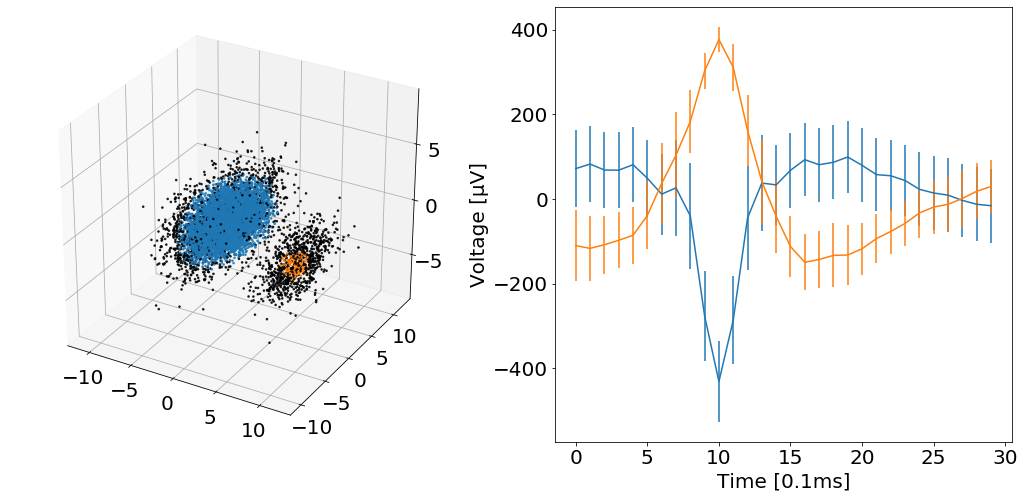

  2%|▏         | 1/41 [00:02<01:24,  2.11s/it]



ELECTRODE:  b'37'
Total spikes 16277

Spike detected as noise 1304

Only one cluster detected

Blue spikes: 14973


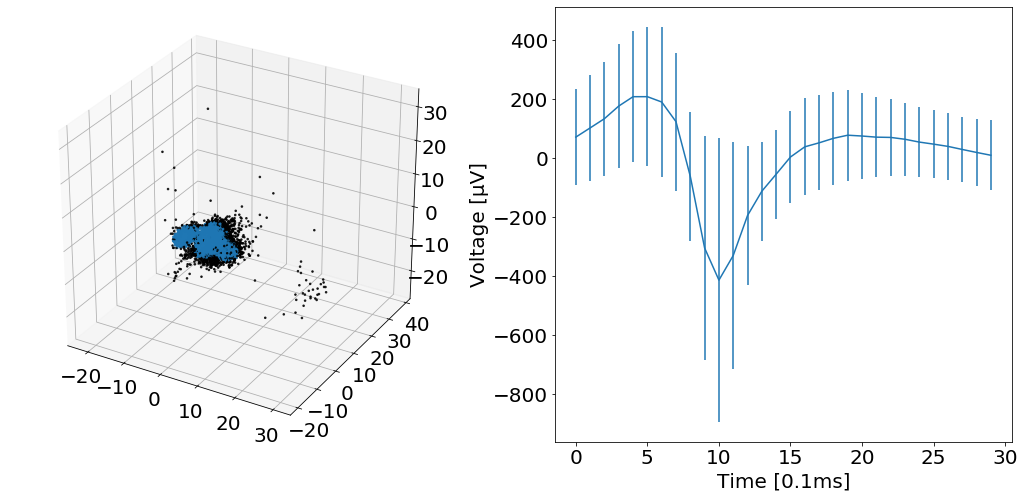

  5%|▍         | 2/41 [00:03<01:09,  1.79s/it]



ELECTRODE:  b'28'
Total spikes 6997

Spike detected as noise 1004

Number of clusters:  2 
The silhouette score is: 0.39774968793892

Blue spikes: 4684

Orange spikes: 1309


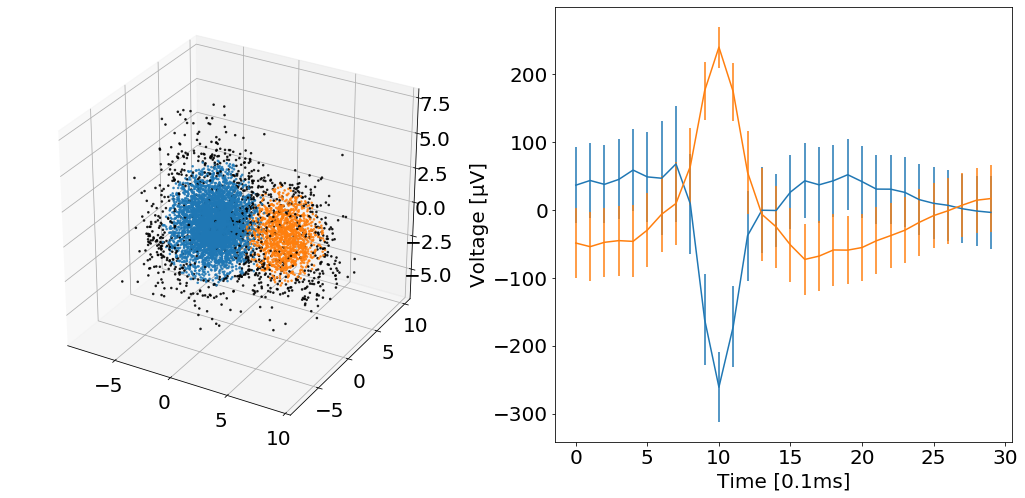

  7%|▋         | 3/41 [00:04<01:02,  1.65s/it]



ELECTRODE:  b'36'
Total spikes 16327

Spike detected as noise 1852

Number of clusters:  2 
The silhouette score is: 0.39812892599986843

Blue spikes: 14356

Orange spikes: 119


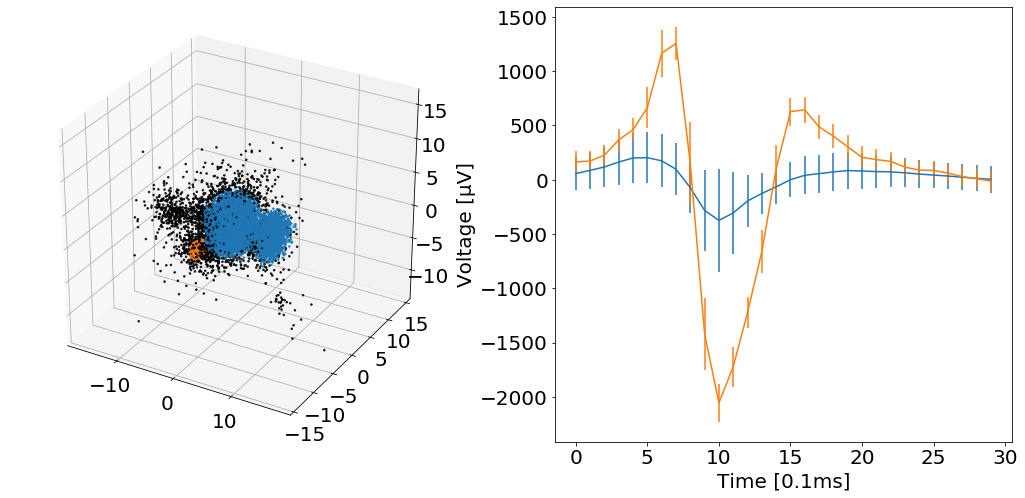

 10%|▉         | 4/41 [00:08<01:26,  2.35s/it]



ELECTRODE:  b'27'
Total spikes 5151

Spike detected as noise 868

Number of clusters:  2 
The silhouette score is: 0.3671768543252933

Blue spikes: 3422

Orange spikes: 861


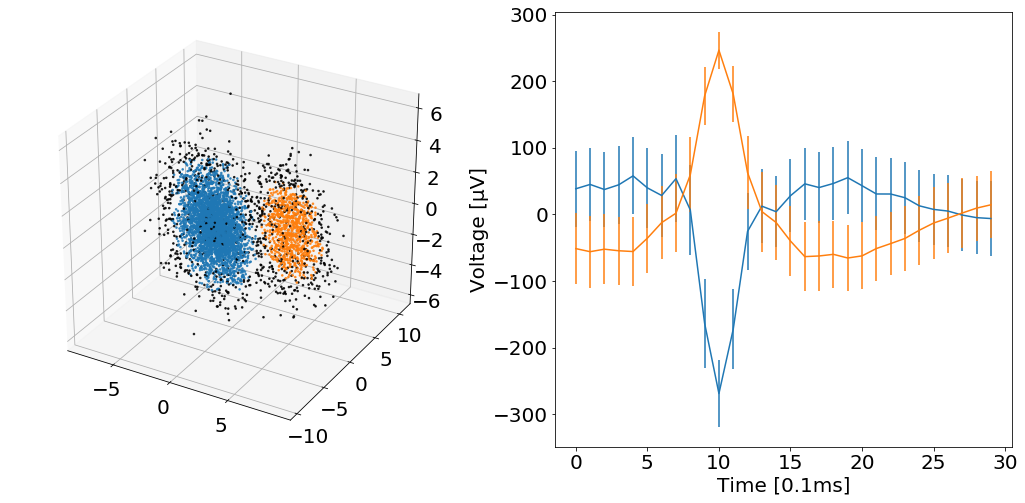

 12%|█▏        | 5/41 [00:09<01:09,  1.92s/it]



ELECTRODE:  b'17'
Total spikes 16011

Spike detected as noise 1574

Only one cluster detected

Blue spikes: 14437


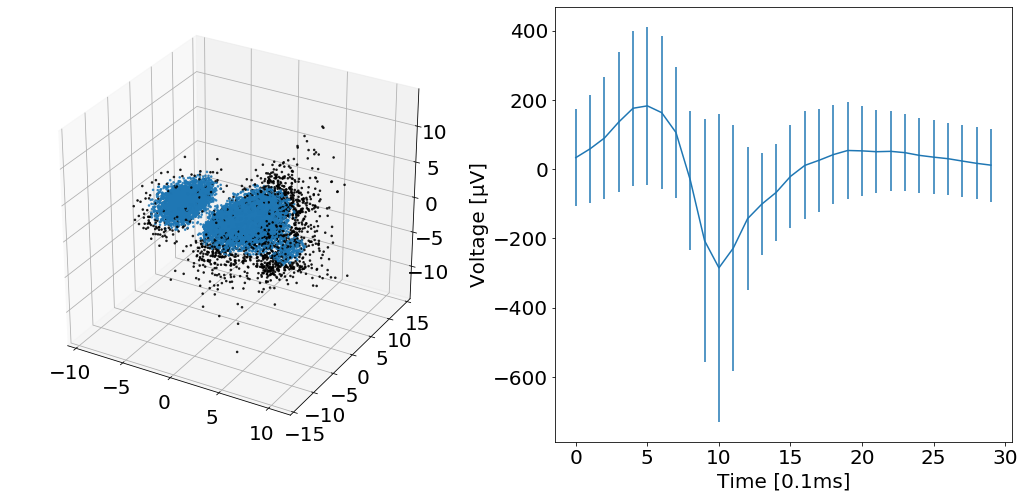

 15%|█▍        | 6/41 [00:10<00:58,  1.67s/it]



ELECTRODE:  b'26'
Total spikes 4413

Spike detected as noise 647

Only one cluster detected

Blue spikes: 3766


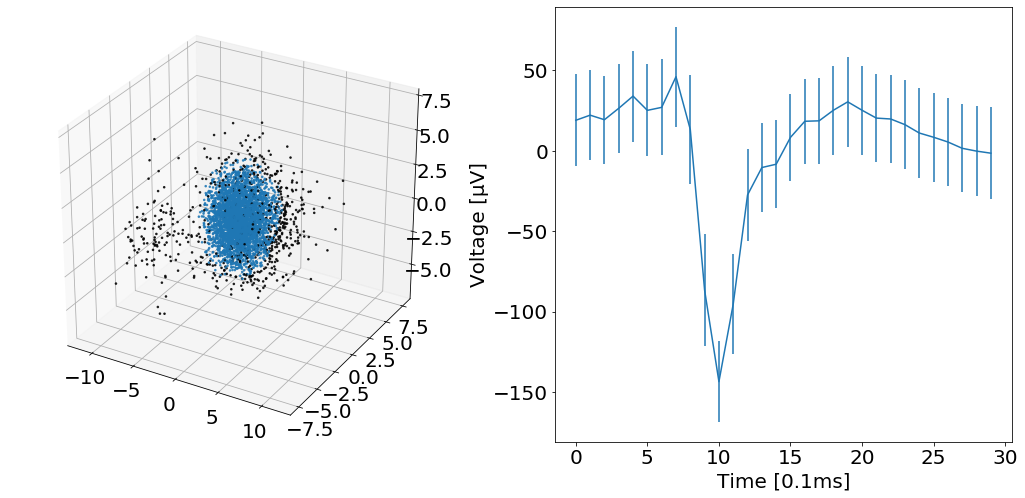

 17%|█▋        | 7/41 [00:10<00:45,  1.33s/it]



ELECTRODE:  b'16'
Total spikes 4626

Spike detected as noise 682

Only one cluster detected

Blue spikes: 3944


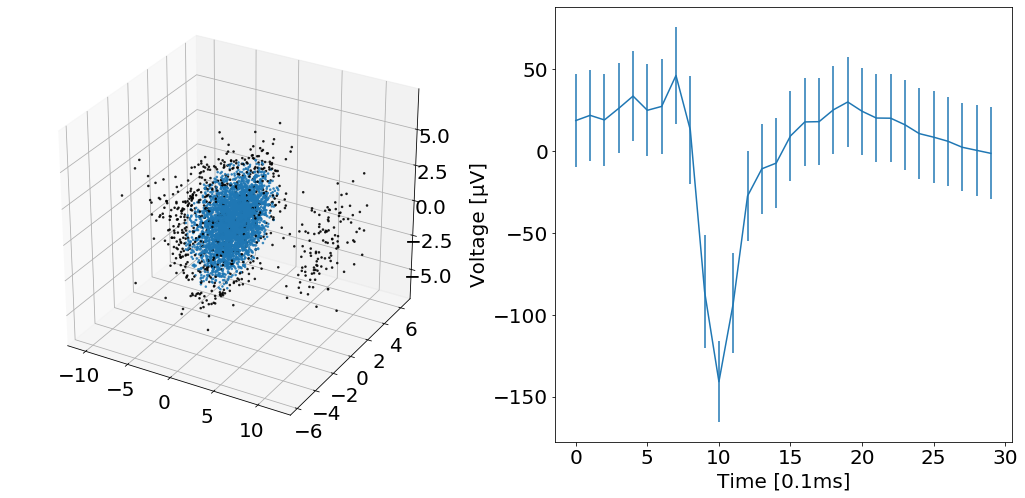

 20%|█▉        | 8/41 [00:11<00:35,  1.08s/it]



ELECTRODE:  b'35'
Total spikes 3494

Spike detected as noise 572

Only one cluster detected

Blue spikes: 2922


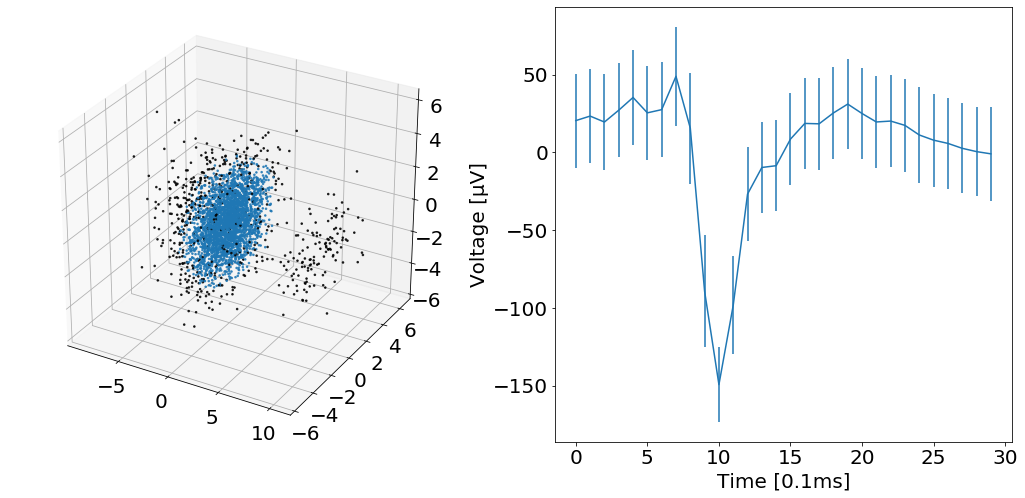

 22%|██▏       | 9/41 [00:11<00:28,  1.10it/s]



ELECTRODE:  b'25'
Total spikes 3835

Spike detected as noise 629

Only one cluster detected

Blue spikes: 3206


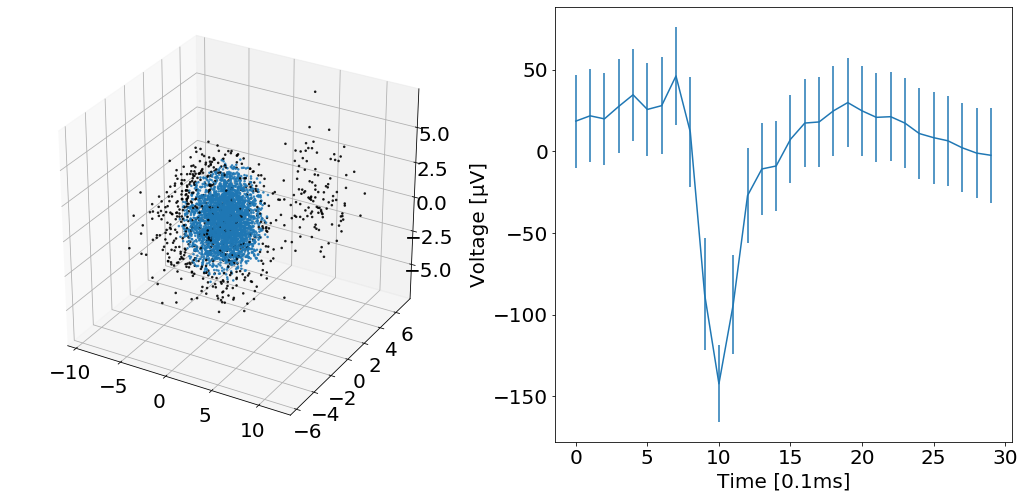

 24%|██▍       | 10/41 [00:12<00:24,  1.28it/s]



ELECTRODE:  b'14'
Total spikes 3216

Spike detected as noise 636

Only one cluster detected

Blue spikes: 2580


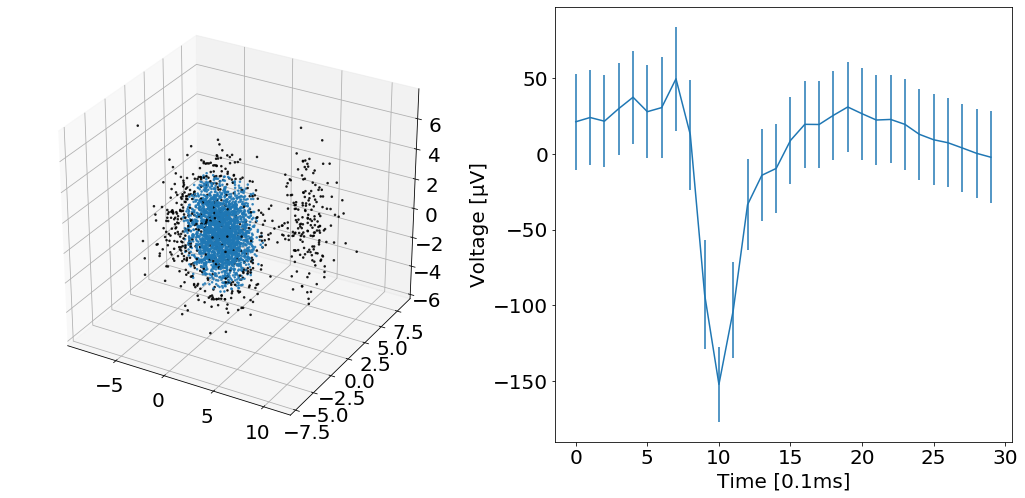

 27%|██▋       | 11/41 [00:12<00:20,  1.45it/s]



ELECTRODE:  b'24'
Total spikes 4703

Spike detected as noise 668

Only one cluster detected

Blue spikes: 4035


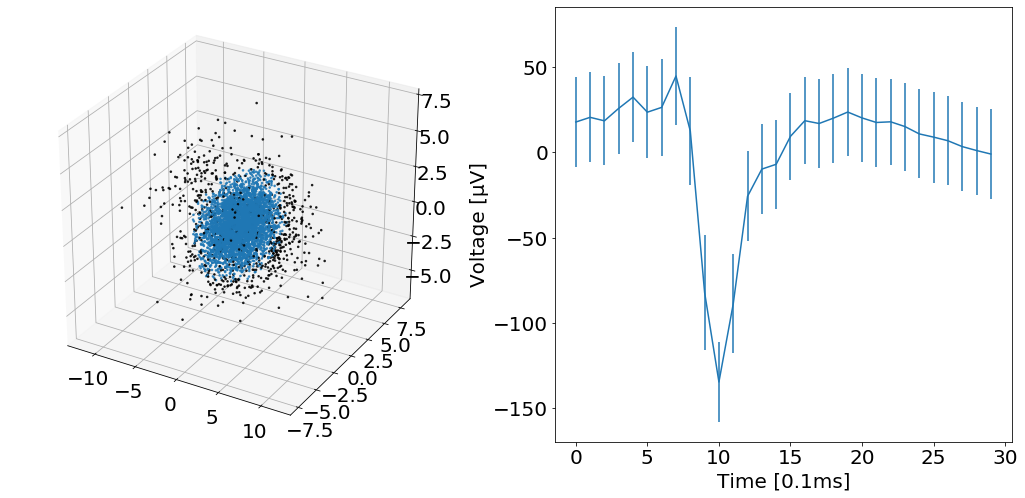

 29%|██▉       | 12/41 [00:13<00:18,  1.56it/s]



ELECTRODE:  b'34'
Total spikes 5851

Spike detected as noise 756

Only one cluster detected

Blue spikes: 5095


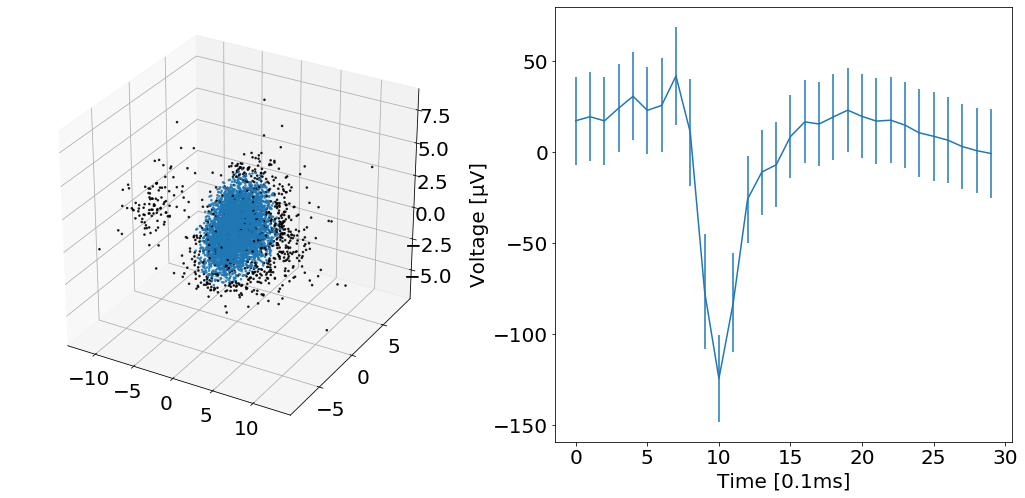

 32%|███▏      | 13/41 [00:14<00:17,  1.62it/s]



ELECTRODE:  b'13'
Total spikes 3671

Spike detected as noise 539

Only one cluster detected

Blue spikes: 3132


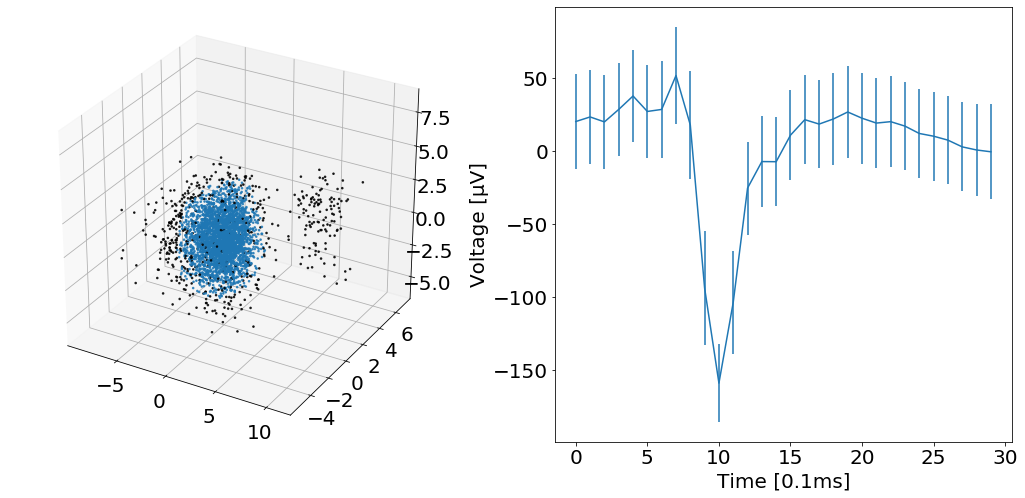

 34%|███▍      | 14/41 [00:14<00:16,  1.67it/s]



ELECTRODE:  b'23'
Total spikes 3697

Spike detected as noise 579

Only one cluster detected

Blue spikes: 3118


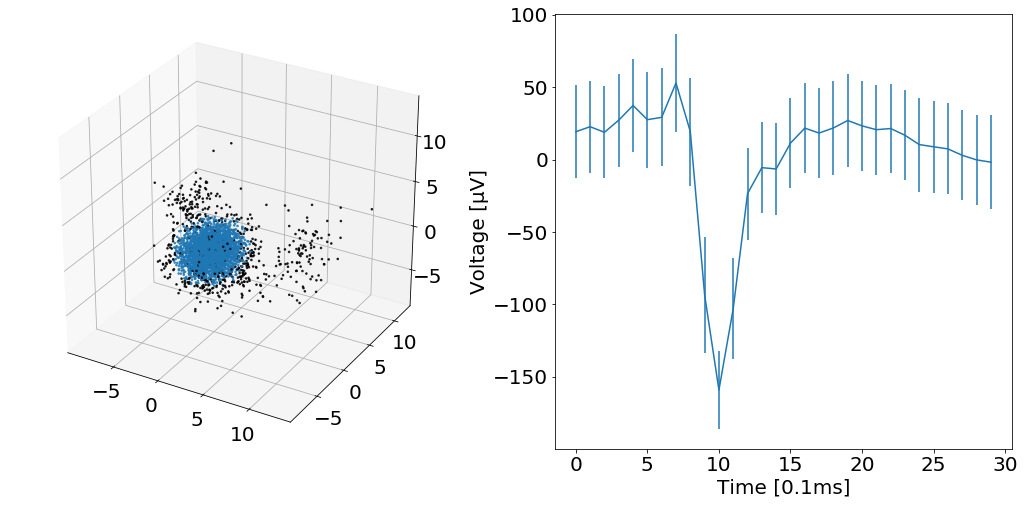

 37%|███▋      | 15/41 [00:15<00:14,  1.78it/s]



ELECTRODE:  b'12'
Total spikes 4418

Spike detected as noise 681

Only one cluster detected

Blue spikes: 3737


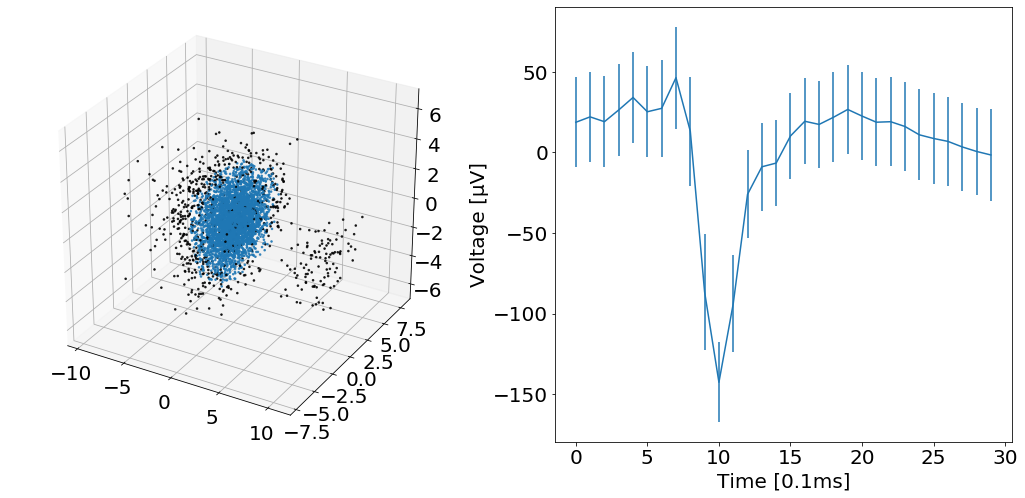

 39%|███▉      | 16/41 [00:15<00:13,  1.81it/s]



ELECTRODE:  b'22'
Total spikes 6261

Spike detected as noise 1195

Only one cluster detected

Blue spikes: 5066


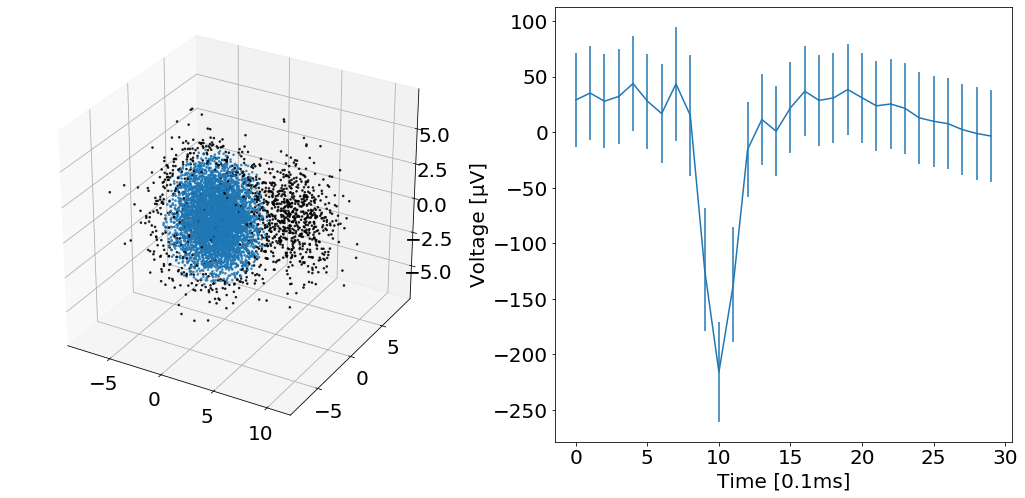

 41%|████▏     | 17/41 [00:16<00:13,  1.79it/s]



ELECTRODE:  b'33'
Total spikes 6313

Spike detected as noise 1025

Number of clusters:  2 
The silhouette score is: 0.3873580642809471

Blue spikes: 4292

Orange spikes: 996


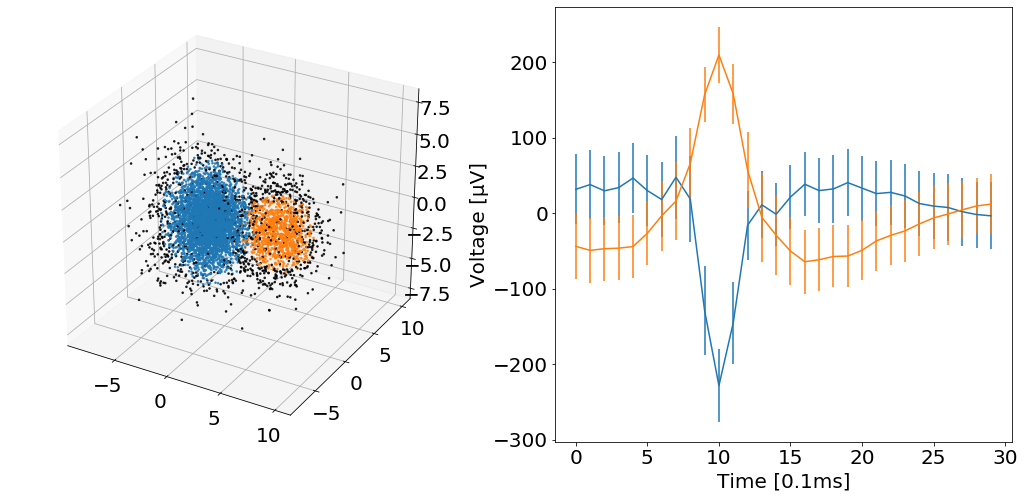

 44%|████▍     | 18/41 [00:17<00:16,  1.36it/s]



ELECTRODE:  b'21'
Total spikes 22983

Spike detected as noise 2108

Number of clusters:  2 
The silhouette score is: 0.4494597461284824

Blue spikes: 18691

Orange spikes: 2184


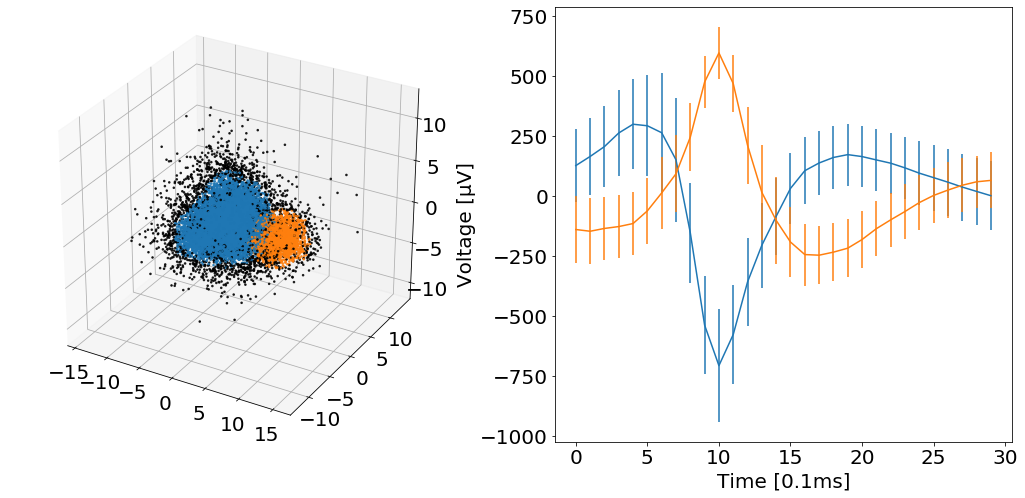

 46%|████▋     | 19/41 [00:24<01:00,  2.74s/it]



ELECTRODE:  b'32'
Total spikes 15104

Spike detected as noise 1370

Only one cluster detected

Blue spikes: 13734


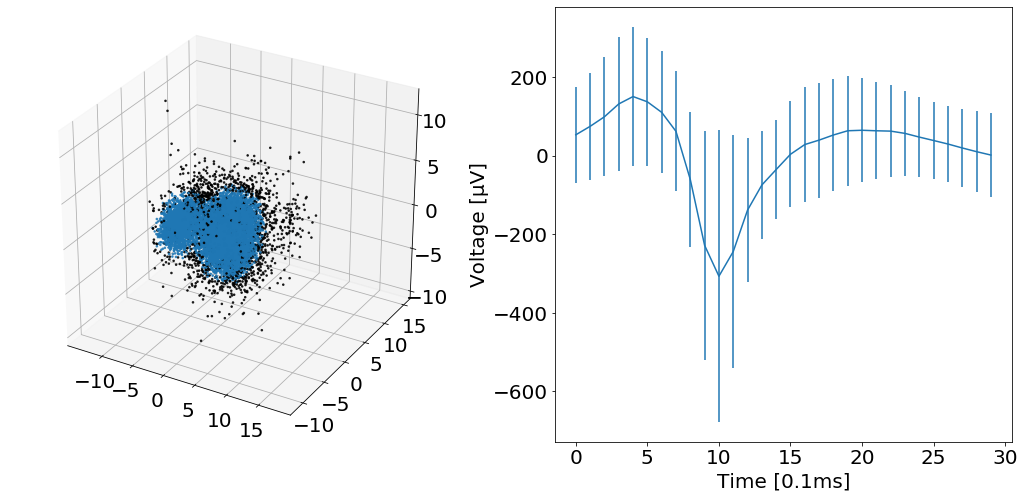

 49%|████▉     | 20/41 [00:25<00:47,  2.25s/it]



ELECTRODE:  b'53'
Total spikes 14242

Spike detected as noise 1619

Number of clusters:  2 
The silhouette score is: 0.40820187666547536

Blue spikes: 10329

Orange spikes: 2294


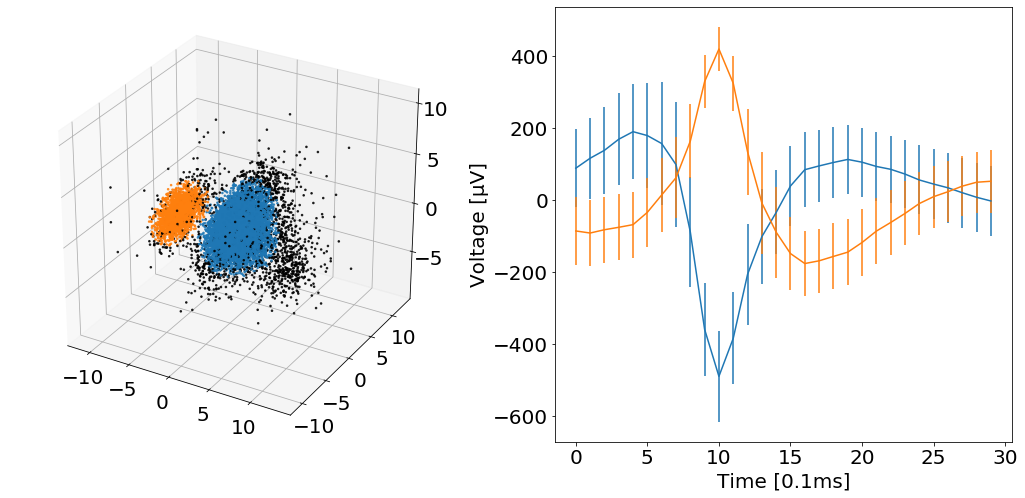

 51%|█████     | 21/41 [00:28<00:50,  2.51s/it]



ELECTRODE:  b'71'
Total spikes 6946

Spike detected as noise 1649

Only one cluster detected

Blue spikes: 5297


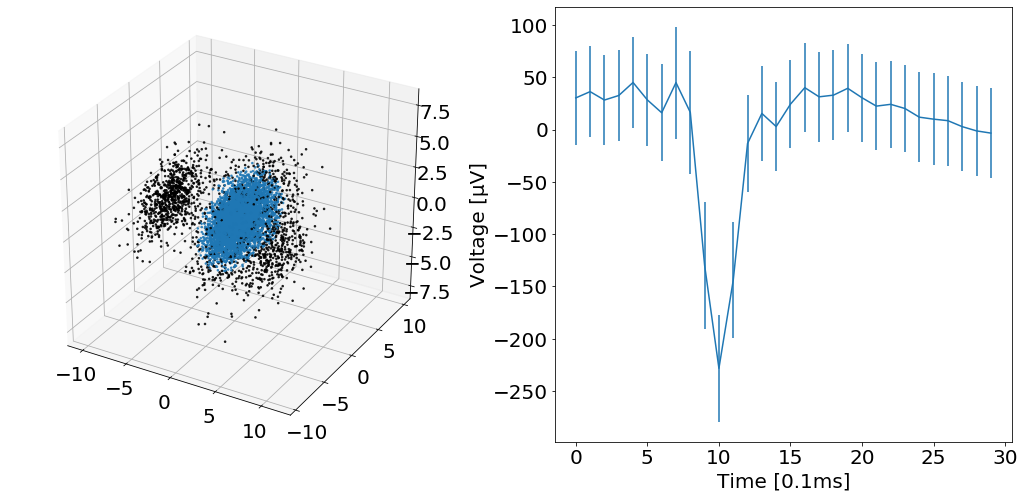

 54%|█████▎    | 22/41 [00:29<00:36,  1.94s/it]



ELECTRODE:  b'63'
Total spikes 13456

Spike detected as noise 1308

Number of clusters:  2 
The silhouette score is: 0.38891645582733864

Blue spikes: 8957

Orange spikes: 3191


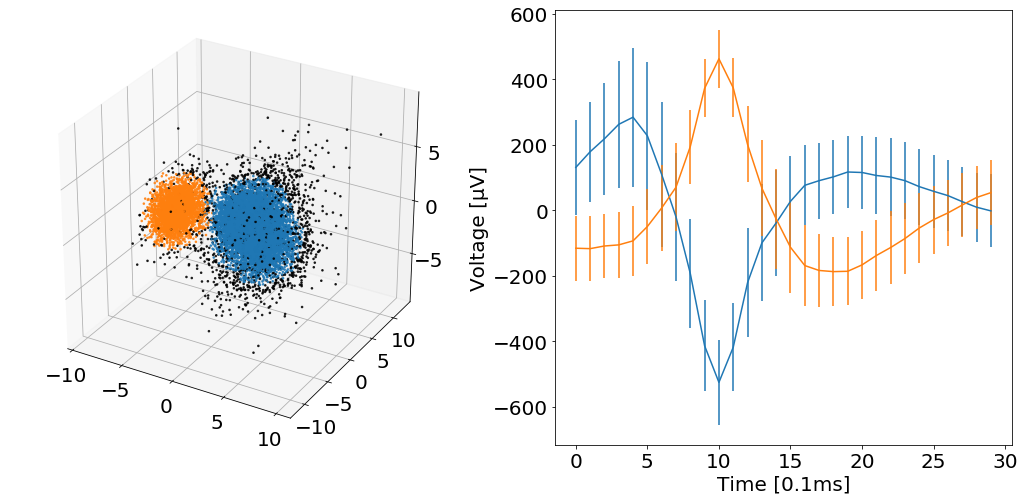

 56%|█████▌    | 23/41 [00:32<00:39,  2.20s/it]



ELECTRODE:  b'72'
Total spikes 27564

Spike detected as noise 2327

Number of clusters:  2 
The silhouette score is: 0.432247982681938

Blue spikes: 21109

Orange spikes: 4128


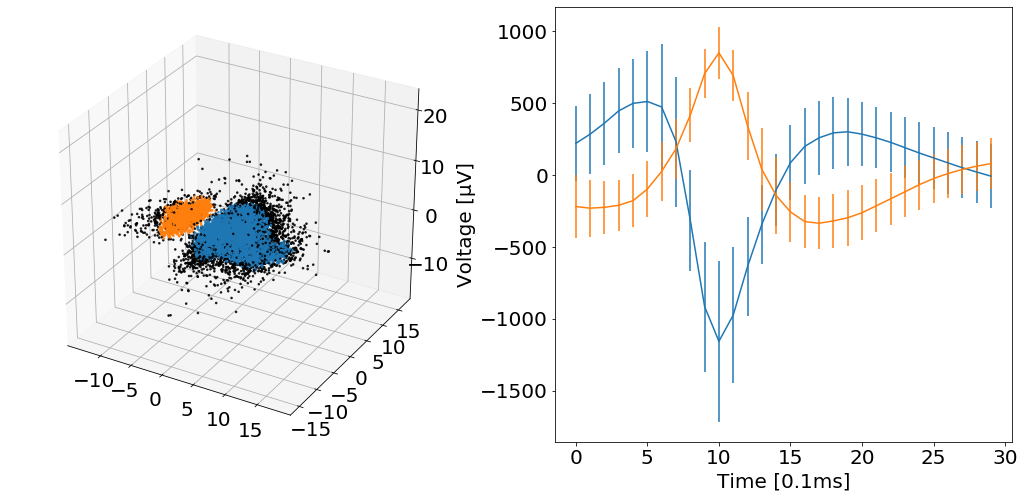

 59%|█████▊    | 24/41 [00:42<01:17,  4.57s/it]



ELECTRODE:  b'82'
Total spikes 6535

Spike detected as noise 1236

Number of clusters:  2 
The silhouette score is: 0.3478818715401076

Blue spikes: 4102

Orange spikes: 1197


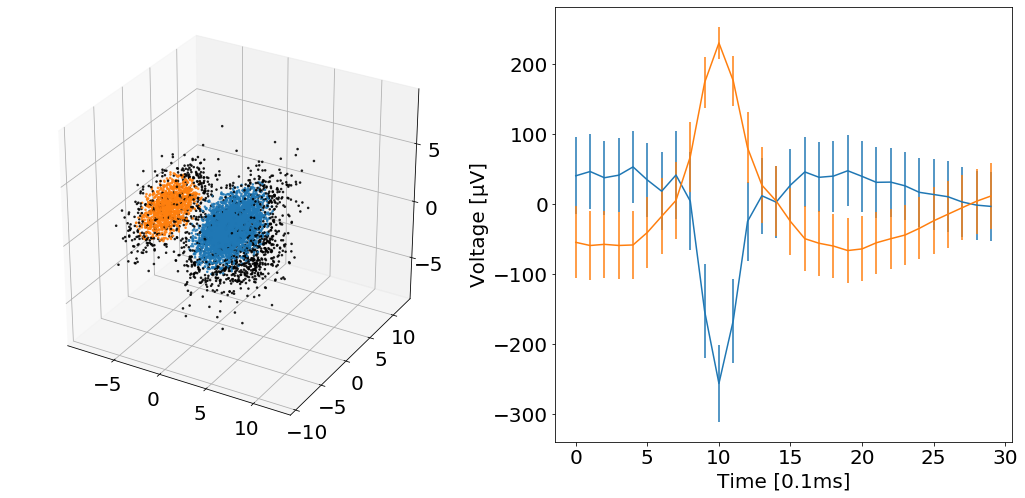

 61%|██████    | 25/41 [00:43<00:56,  3.56s/it]



ELECTRODE:  b'73'
Total spikes 5101

Spike detected as noise 698

Only one cluster detected

Blue spikes: 4403


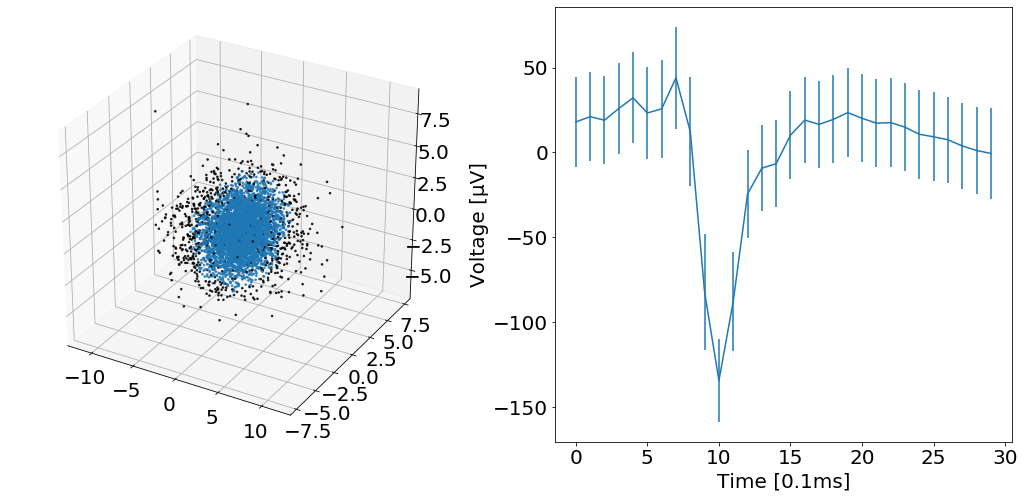

 63%|██████▎   | 26/41 [00:44<00:39,  2.65s/it]



ELECTRODE:  b'83'
Total spikes 5701

Spike detected as noise 700

Only one cluster detected

Blue spikes: 5001


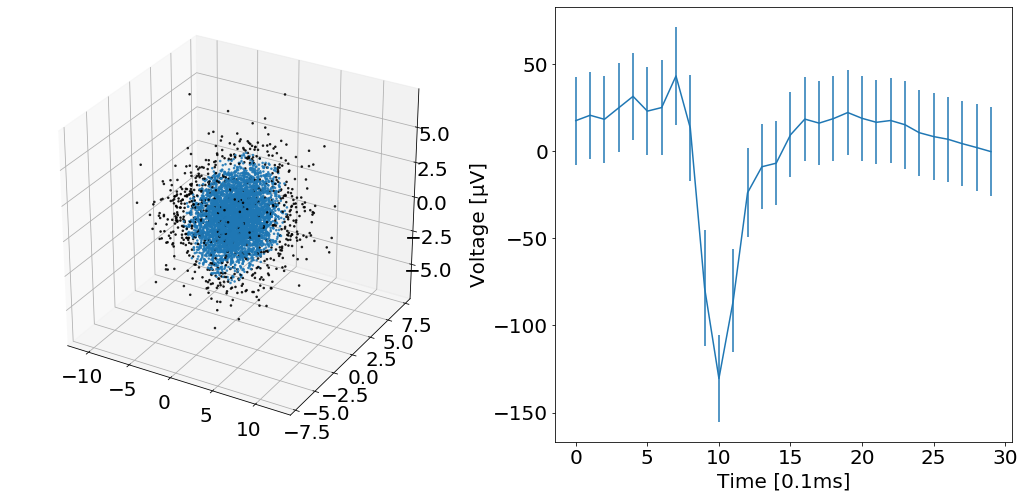

 66%|██████▌   | 27/41 [00:44<00:28,  2.03s/it]



ELECTRODE:  b'64'
Total spikes 5028

Spike detected as noise 660

Only one cluster detected

Blue spikes: 4368


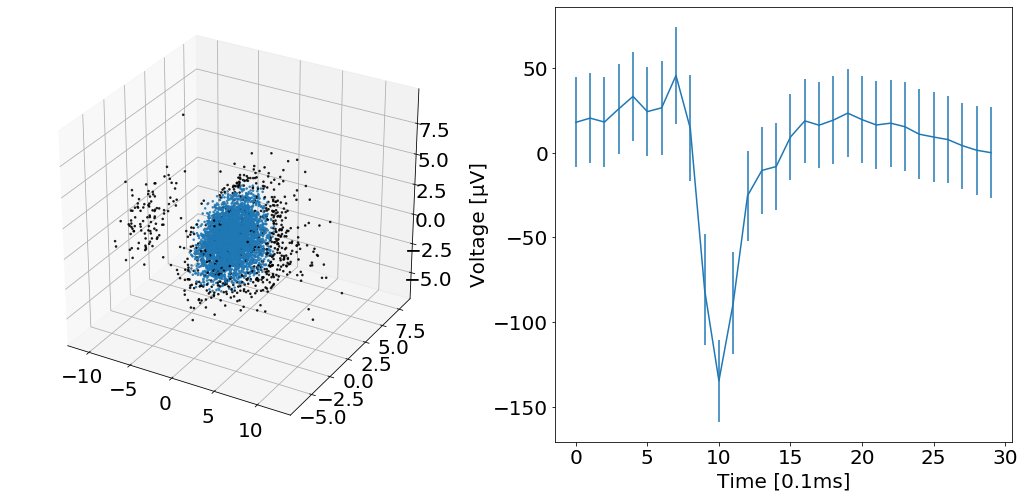

 68%|██████▊   | 28/41 [00:45<00:20,  1.58s/it]



ELECTRODE:  b'74'
Total spikes 5209

Spike detected as noise 652

Only one cluster detected

Blue spikes: 4557


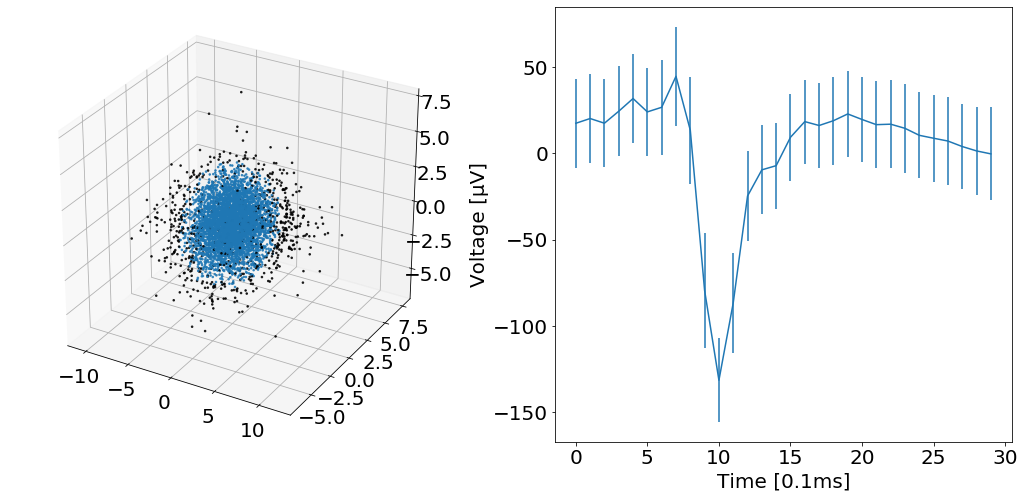

 71%|███████   | 29/41 [00:45<00:15,  1.27s/it]



ELECTRODE:  b'84'
Total spikes 4989

Spike detected as noise 724

Only one cluster detected

Blue spikes: 4265


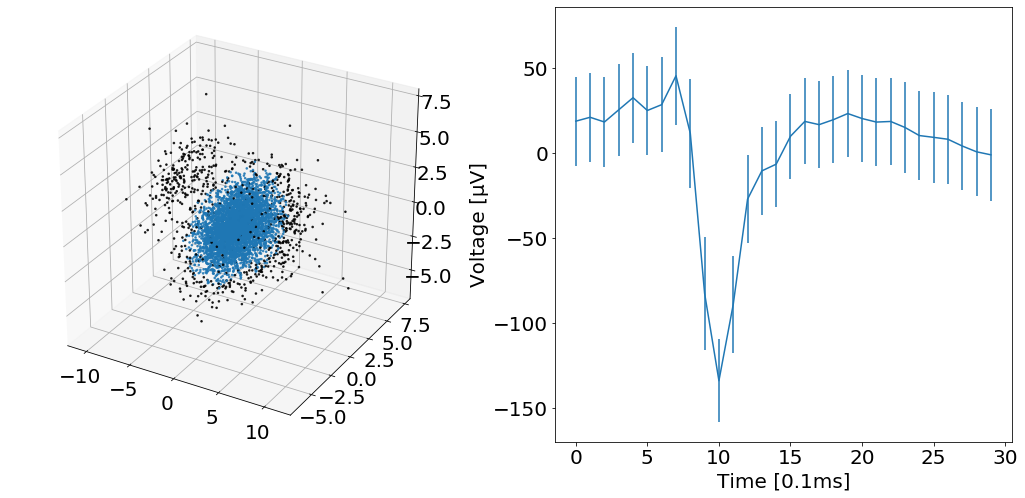

 73%|███████▎  | 30/41 [00:46<00:11,  1.05s/it]



ELECTRODE:  b'85'
Total spikes 4934

Spike detected as noise 660

Only one cluster detected

Blue spikes: 4274


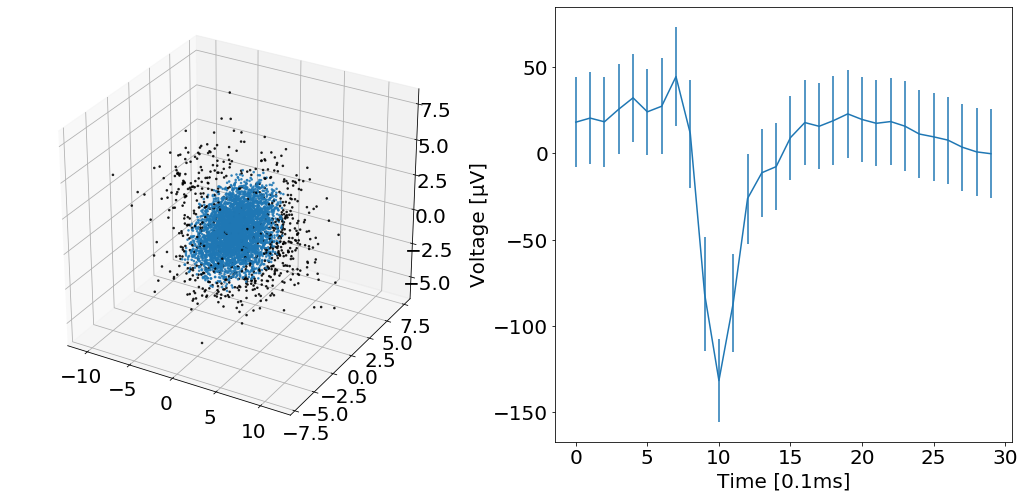

 76%|███████▌  | 31/41 [00:46<00:09,  1.11it/s]



ELECTRODE:  b'75'
Total spikes 9850

Spike detected as noise 895

Only one cluster detected

Blue spikes: 8955


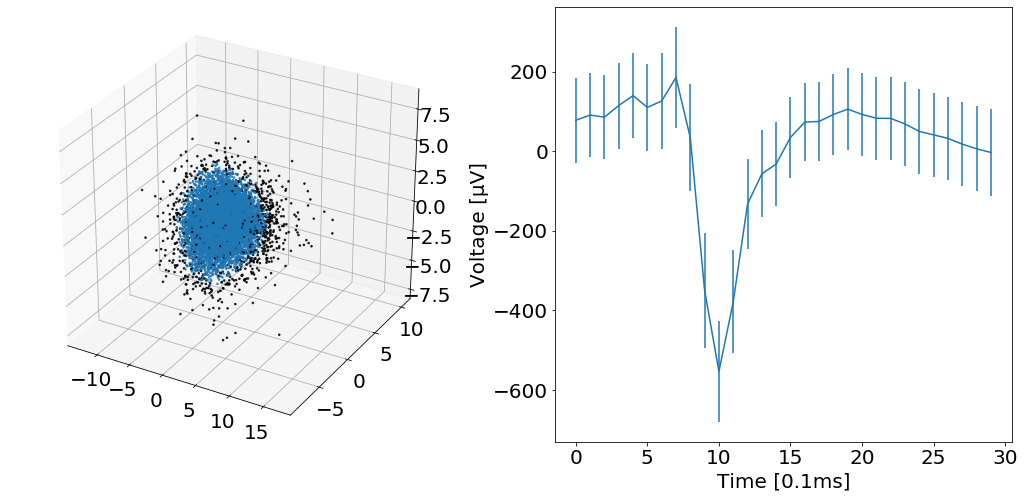

 78%|███████▊  | 32/41 [00:47<00:07,  1.13it/s]



ELECTRODE:  b'65'
Total spikes 5621

Spike detected as noise 715

Only one cluster detected

Blue spikes: 4906


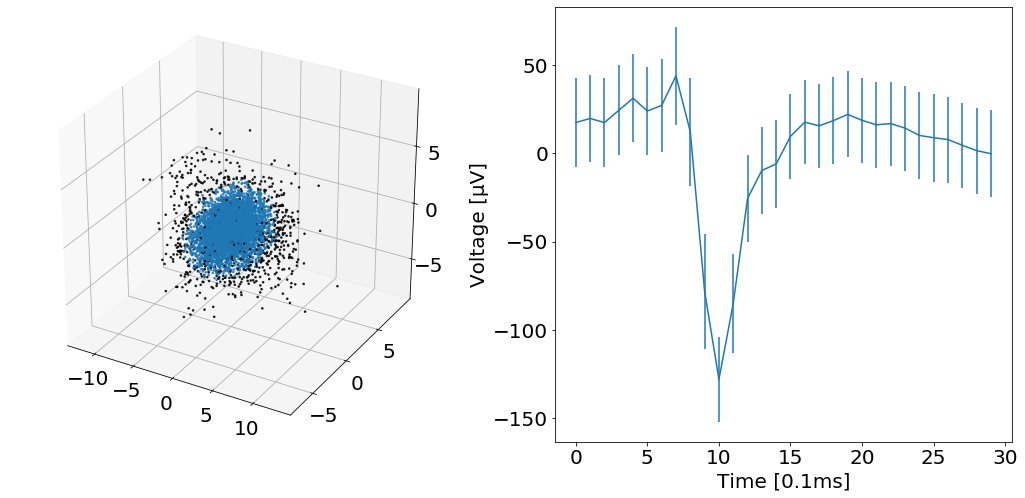

 80%|████████  | 33/41 [00:48<00:06,  1.25it/s]



ELECTRODE:  b'86'
Total spikes 5312

Spike detected as noise 719

Only one cluster detected

Blue spikes: 4593


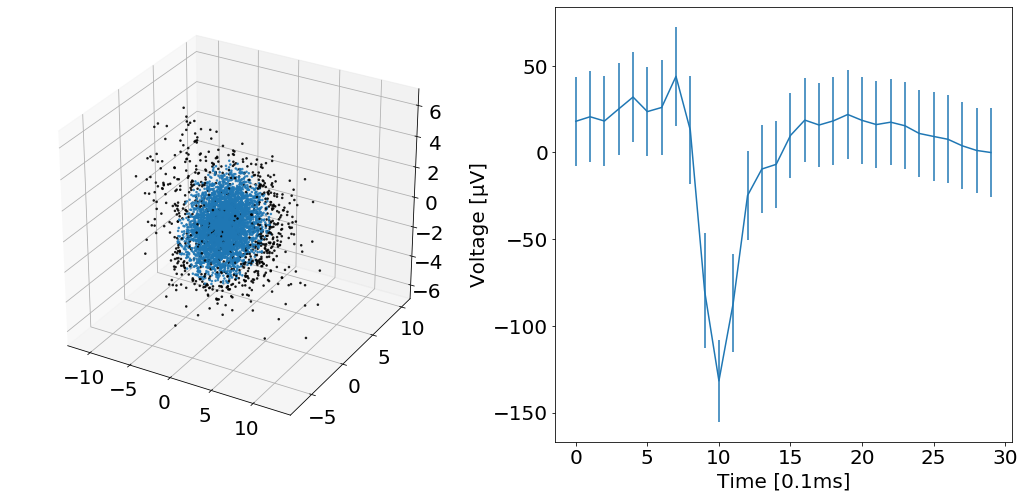

 83%|████████▎ | 34/41 [00:48<00:05,  1.38it/s]



ELECTRODE:  b'76'
Total spikes 5809

Spike detected as noise 714

Only one cluster detected

Blue spikes: 5095


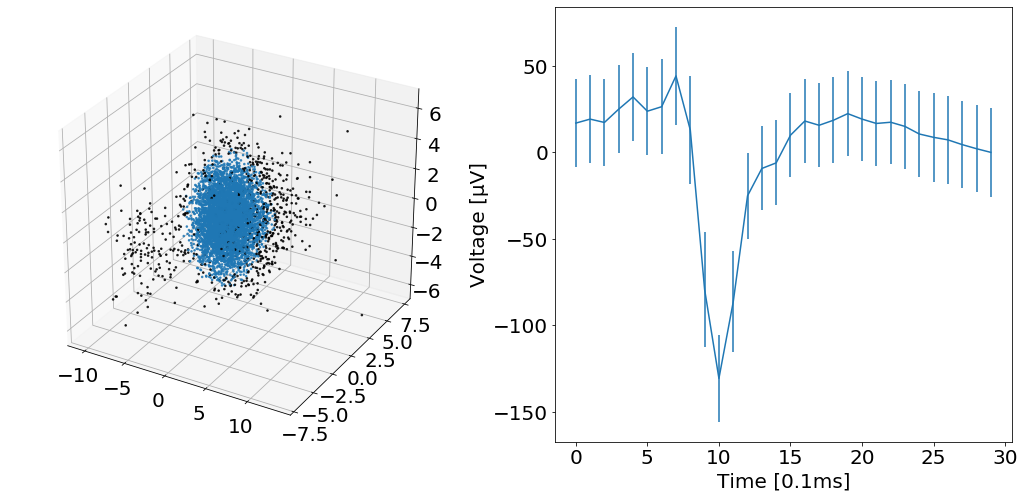

 85%|████████▌ | 35/41 [00:49<00:04,  1.47it/s]



ELECTRODE:  b'87'
Total spikes 5159

Spike detected as noise 686

Only one cluster detected

Blue spikes: 4473


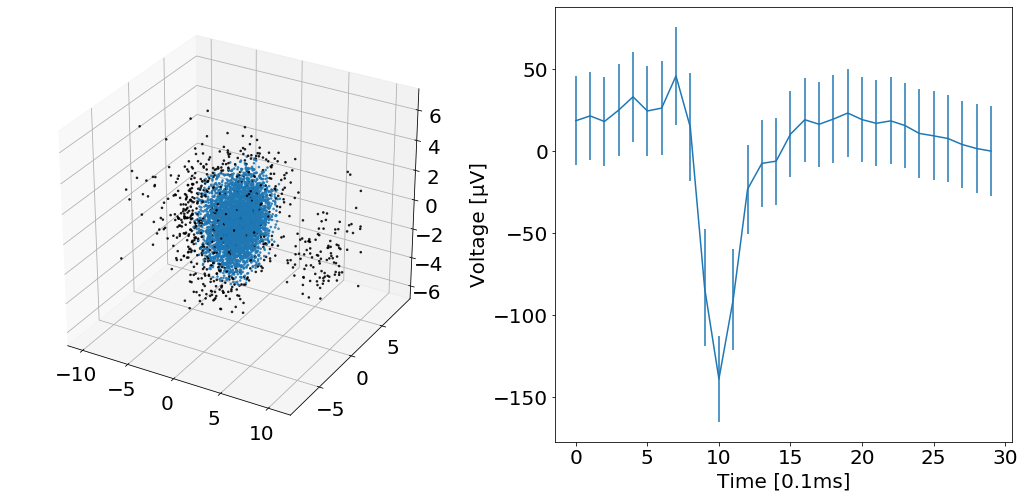

 88%|████████▊ | 36/41 [00:50<00:03,  1.55it/s]



ELECTRODE:  b'77'
Total spikes 26512

Spike detected as noise 2089

Only one cluster detected

Blue spikes: 24423


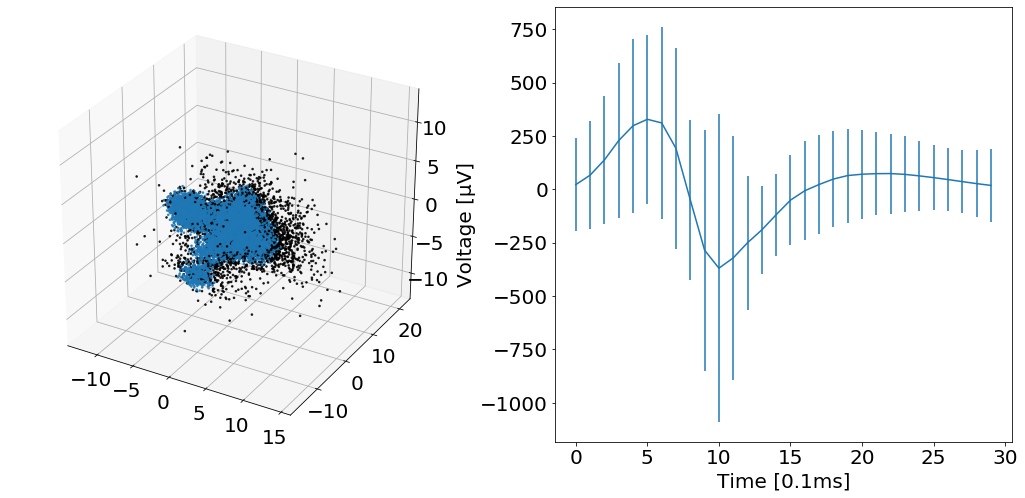

 90%|█████████ | 37/41 [00:52<00:04,  1.04s/it]



ELECTRODE:  b'66'
Total spikes 10587

Spike detected as noise 1107

Number of clusters:  2 
The silhouette score is: 0.4068774155620933

Blue spikes: 5574

Orange spikes: 3906


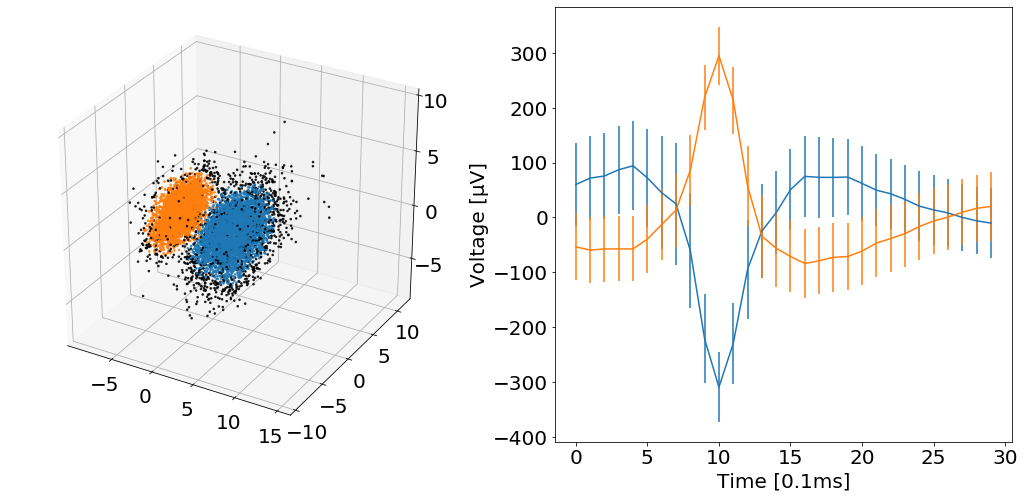

 93%|█████████▎| 38/41 [00:54<00:04,  1.48s/it]



ELECTRODE:  b'78'
Total spikes 11935

Spike detected as noise 1204

Only one cluster detected

Blue spikes: 10731


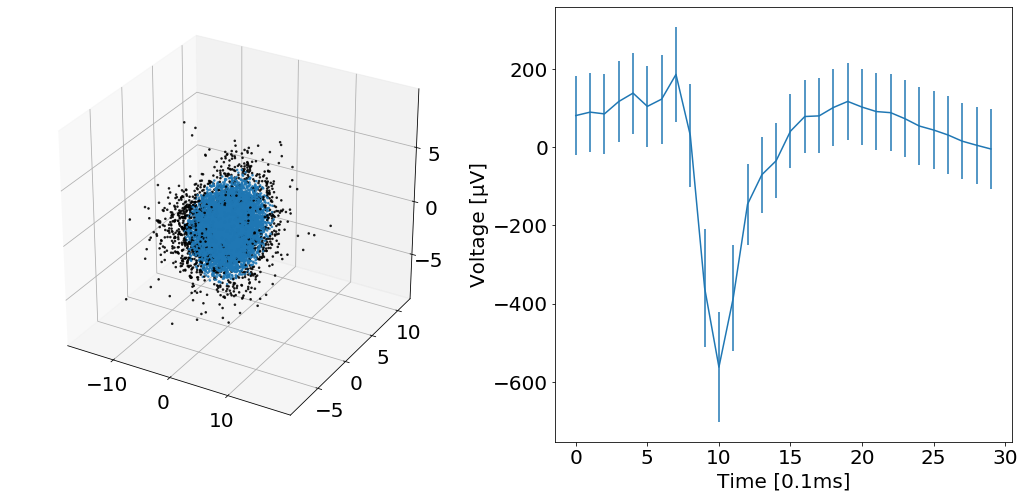

 95%|█████████▌| 39/41 [00:55<00:02,  1.30s/it]



ELECTRODE:  b'67'
Total spikes 20299

Spike detected as noise 1862

Number of clusters:  2 
The silhouette score is: 0.3739665629907749

Blue spikes: 18314

Orange spikes: 123


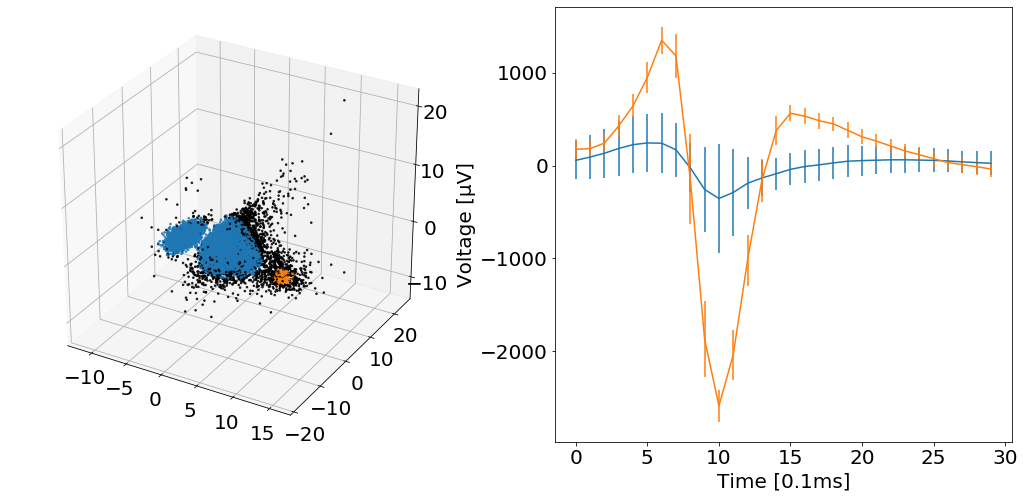

 98%|█████████▊| 40/41 [01:01<00:02,  2.73s/it]



ELECTRODE:  b'57'
Total spikes 8676

Spike detected as noise 996

Number of clusters:  2 
The silhouette score is: 0.4007138954487892

Blue spikes: 5514

Orange spikes: 2166


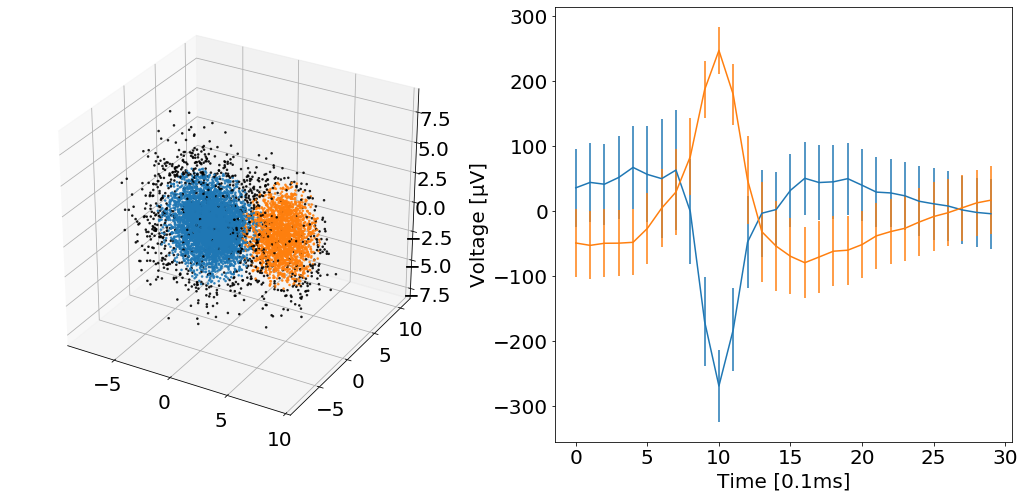

100%|██████████| 41/41 [01:03<00:00,  1.55s/it]


In [19]:
#DBSCAN CLUSTERING
cluster = []
for electrode in tqdm(filtered_readings.columns):
    print("\n\nELECTRODE: ",electrode)
    cluster.append(perform_pca_DBSCAN(extracted[legend[electrode].values[0]],np.array(aligned_indexes[legend[electrode].values[0]]),fs = fs,n_comp=3, distanza = 1.1, punti_min = 60))

In [20]:
#K-MEANS CLUSTERING
#cluster = []
#for electrode in tqdm(filtered_readings.columns):
#    print("\n\nELECTRODE: ",electrode)
#    cluster.append(perform_pca_kmeans(extracted[legend[electrode].values[0]],np.array(aligned_indexes[legend[electrode].values[0]]),fs = fs,n_comp=3, centroids=False))

In [21]:
#HIERARCHICAL CLUSTERING
#cluster = []
#for electrode in tqdm(filtered_readings.columns):
#    print("\n\nELECTRODE: ",electrode)
#    cluster.append(perform_pca_gerarchico(extracted[legend[electrode].values[0]],np.array(aligned_indexes[legend[electrode].values[0]]),fs = fs,n_comp=3, centroids=False))

In [22]:
for clu in cluster:
    print(len(clu))

3
2
3
3
3
2
2
2
2
2
2
2
2
2
2
2
2
3
3
2
3
2
3
3
3
2
2
2
2
2
2
2
2
2
2
2
2
3
2
3
3


In [23]:
neurons = []
for electrode in cluster:
    for neuron in electrode:
        neurons.append(neuron)

In [24]:
len(neurons)

95

In [25]:
adj_neur=[]

counter = 0
max_len=0

for neu in neurons:
    print('counter: ',counter,neu.shape[0])
    if neu.shape[0]>max_len:
        max_len=neu.shape[0]
    counter+=1
for neuron in neurons:
    if neuron.shape[0]<max_len:
        diff = max_len-neuron.shape[0]
        adj_neur.append(np.concatenate((neuron,np.zeros([diff]))))
    

counter:  0 1724
counter:  1 7755
counter:  2 135
counter:  3 1304
counter:  4 14973
counter:  5 1004
counter:  6 4684
counter:  7 1309
counter:  8 1852
counter:  9 14356
counter:  10 119
counter:  11 868
counter:  12 3422
counter:  13 861
counter:  14 1574
counter:  15 14437
counter:  16 647
counter:  17 3766
counter:  18 682
counter:  19 3944
counter:  20 572
counter:  21 2922
counter:  22 629
counter:  23 3206
counter:  24 636
counter:  25 2580
counter:  26 668
counter:  27 4035
counter:  28 756
counter:  29 5095
counter:  30 539
counter:  31 3132
counter:  32 579
counter:  33 3118
counter:  34 681
counter:  35 3737
counter:  36 1195
counter:  37 5066
counter:  38 1025
counter:  39 4292
counter:  40 996
counter:  41 2108
counter:  42 18691
counter:  43 2184
counter:  44 1370
counter:  45 13734
counter:  46 1619
counter:  47 10329
counter:  48 2294
counter:  49 1649
counter:  50 5297
counter:  51 1308
counter:  52 8957
counter:  53 3191
counter:  54 2327
counter:  55 21109
counter:  

In [26]:
save_data = 'After'+name_data+'.txt'

In [27]:
np.savetxt(save_data,adj_neur, delimiter=', ', fmt='%12.8f')